In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import umap
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, wilcoxon, spearmanr


### Data preparation

In [2]:
df = pd.read_json("results/task2/task2_data.json", lines=True)
# --- Step 1: Expand lists to 2D arrays ---
ref_array = np.vstack(df["ref_embeddings"].to_numpy())
gen_array = np.vstack(df["gen_embeddings"].to_numpy())

zone_path = "datasets/job_zone.xlsx"
zone = pd.read_excel(zone_path)
zone = zone[['Title', 'Job Zone']]
zone.columns = ['title', 'zone']
df = df.merge(zone, left_on='title', right_on='title', how='left')
df["area"] = df["code"].apply(lambda x: x.split("-")[0])
df["area"] = df["area"].astype("category")
df["code"] = df["code"].astype("category")
df["zone"] = df["zone"].astype("category")
df["model"] = df["model"].replace("llama 70b", "llama70b")
df["model"] = df["model"].replace("llama 3b", "llama3b")
df["model"] = df["model"].apply(lambda x: x.split(" ")[0] if " " in x else x)

In [3]:
rows = []
# --- Process Reference Embeddings ---

df_ref_unique = df.drop_duplicates(subset=['code', 'model', 'iteration'])

for index, row in df_ref_unique.iterrows():
    # Normalize the reference embedding. reshape(1, -1) is used because normalize expects 2D array.
    normalized_ref_emb = normalize(np.array(row['ref_embeddings']).reshape(1, -1))[0]
    rows.append({
        'code': row['code'],
        'model': row['model'],
        'prompt': 'ref',
        'iteration': row['iteration'],
        'embedding': normalized_ref_emb.tolist()
    })

# --- Process Generated Embeddings for 'benchmark' prompt ---
# Filter the original DataFrame to get only rows where prompt is 'benchmark'.
df_benchmark = df[df['prompt'] == 'benchmark']
for index, row in df_benchmark.iterrows():
    # Normalize the generated embedding for 'benchmark'.
    normalized_gen_emb = normalize(np.array(row['gen_embeddings']).reshape(1, -1))[0]
    rows.append({
        'code': row['code'],
        'model': row['model'],
        'prompt': 'benchmark',
        'iteration': row['iteration'],
        'embedding': normalized_gen_emb.tolist()
    })

# --- Process Generated Embeddings for 'persona' prompt ---
# Filter the original DataFrame to get only rows where prompt is 'persona'.
df_persona = df[df['prompt'] == 'persona']
for index, row in df_persona.iterrows():
    # Normalize the generated embedding for 'persona'.
    normalized_gen_emb = normalize(np.array(row['gen_embeddings']).reshape(1, -1))[0]
    rows.append({
        'code': row['code'],
        'model': row['model'],
        'prompt': 'persona',
        'iteration': row['iteration'],
        'embedding': normalized_gen_emb.tolist()
    })

# Create the final DataFrame from the collected rows
df_all_embeddings = pd.DataFrame(rows)
df_all_embeddings['area'] = df_all_embeddings['code'].apply(lambda x: x.split("-")[0])
df_all_embeddings

,code,model,prompt,iteration,embedding,area
0,13-2011.00,deepseek-r1,ref,0,"[0.05778160785332616, 0.01709720408727697, 0.0...",13
1,27-2011.00,deepseek-r1,ref,0,"[0.05005398370231716, -0.02981496028224901, 0....",27
2,15-2011.00,deepseek-r1,ref,0,"[0.05492892375272339, 0.015017905886327511, -0...",15
3,29-1291.00,deepseek-r1,ref,0,"[0.053923153767784684, -0.0455680314558533, 0....",29
4,29-1141.01,deepseek-r1,ref,0,"[0.05438733459911409, -0.06101214072395544, -0...",29
...,...,...,...,...,...,...
105475,15-1212.00,mistral,persona,2,"[0.03437775664310248, 0.04420883218474737, -2....",15
105476,15-1299.09,mistral,persona,2,"[0.051093116181008175, 0.004663755680010529, -...",15
105477,51-9061.00,mistral,persona,2,"[0.013496475784975733, -0.02807629763663796, -...",51
105478,25-9031.00,mistral,persona,2,"[0.08827292825751913, -0.03991977087378076, -0...",25


In [73]:
# Average embeddings correctly for each group
def average_embedding(embeddings):
	arrs = np.stack(embeddings)
	return arrs.mean(axis=0)

df_all_embeddings_avg = df_all_embeddings.groupby(['code', 'model', 'prompt','area'])['embedding'].apply(average_embedding).reset_index()
df_all_embeddings_avg

,code,model,prompt,area,embedding
0,11-1011.00,deepseek-r1,benchmark,11,"[0.06001701198521865, 0.007385621778832914, -0..."
1,11-1011.00,deepseek-r1,persona,11,"[0.048555013813699185, 0.001339454172301693, -..."
2,11-1011.00,deepseek-r1,ref,11,"[0.0471675836018035, -0.019213052215599467, 0...."
3,11-1011.00,llama3b,benchmark,11,"[0.058747649047549755, -0.008112463845566466, ..."
4,11-1011.00,llama3b,persona,11,"[0.05739399019235834, 0.0018368545203588371, -..."
...,...,...,...,...,...
10543,53-7121.00,llama70b,persona,53,"[0.004284111738706632, 0.03530827392471518, -0..."
10544,53-7121.00,llama70b,ref,53,"[-0.023427307399909062, 0.015767238865333155, ..."
10545,53-7121.00,mistral,benchmark,53,"[0.013810852373519217, 0.017196451317560302, 0..."
10546,53-7121.00,mistral,persona,53,"[0.01564492935037696, 0.027022842345182492, 0...."


In [22]:
# Step 1: Group by model and job code
groups = df_all_embeddings_avg.groupby(['model', 'code'])

# Step 2: Compute cosine similarity between each benchmark/persona and the reference
similarity_rows = []

for (model, code), group in groups:
    # Extract rows by prompt type
    ref_row = group[group['prompt'] == 'ref']
    bench_row = group[group['prompt'] == 'benchmark']
    pers_row = group[group['prompt'] == 'persona']
    
    if len(ref_row) != 1:
        continue  # Skip if ref embedding is missing
    ref_emb = np.array(ref_row['embedding'].values[0]).reshape(1, -1)
    
    for prompt, row in [('benchmark', bench_row), ('persona', pers_row)]:
        if len(row) != 1:
            continue  # Skip if prompt type is missing
        gen_emb = np.array(row['embedding'].values[0]).reshape(1, -1)
        sim = cosine_similarity(ref_emb, gen_emb).item()
        
        similarity_rows.append({
            'model': model,
            'prompt': prompt,
            'similarity': sim,
            'code': code
        })

# Step 3: Create a new DataFrame for plotting
df_des = pd.DataFrame(similarity_rows)

### Descriptive stats

In [24]:
df_des['area'] = df_des['code'].apply(lambda x: x.split("-")[0])
df_des['area'] = df_des['area'].astype("category")
zone = pd.read_excel(zone_path)
zone = zone[['O*NET-SOC Code', 'Job Zone']]
zone.columns = ['code', 'zone']
df_des = df_des.merge(zone, left_on='code', right_on='code', how='left')
df_des

,model,prompt,similarity,code,area,zone
0,deepseek-r1,benchmark,0.860483,11-1011.00,11,5
1,deepseek-r1,persona,0.804572,11-1011.00,11,5
2,deepseek-r1,benchmark,0.865418,11-1011.03,11,5
3,deepseek-r1,persona,0.857544,11-1011.03,11,5
4,deepseek-r1,benchmark,0.844367,11-1021.00,11,4
...,...,...,...,...,...,...
7027,mistral,persona,0.902894,53-7073.00,53,2
7028,mistral,benchmark,0.881718,53-7081.00,53,2
7029,mistral,persona,0.901099,53-7081.00,53,2
7030,mistral,benchmark,0.890988,53-7121.00,53,2


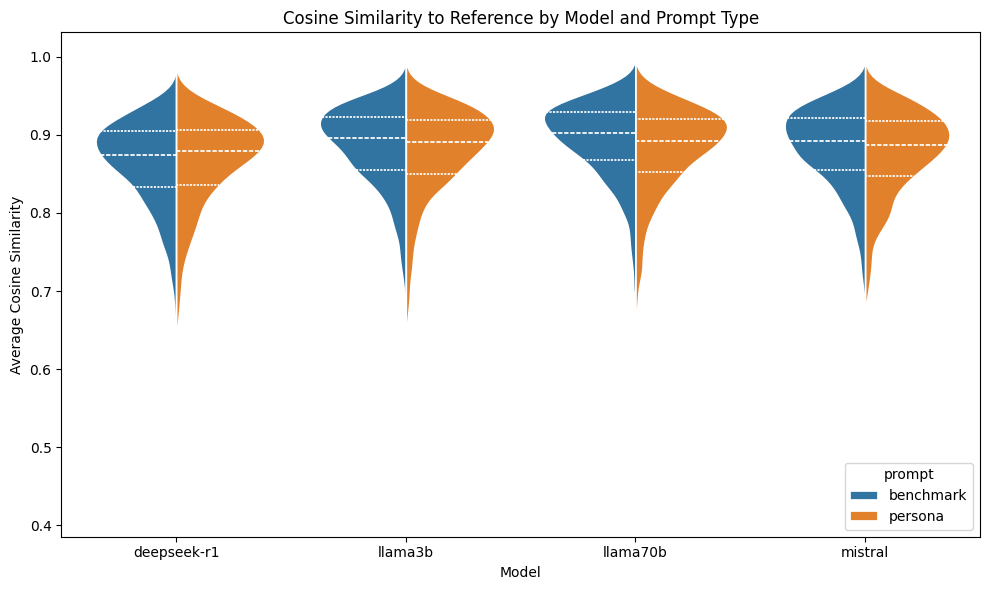

In [25]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_des, 
    x="model", 
    y="similarity", 
    hue="prompt", 
    split=True, 
    inner="quartile",  # You can tune this
    alpha=1, 
    edgecolor="white"
)
plt.title("Cosine Similarity to Reference by Model and Prompt Type")
plt.xlabel("Model")
plt.ylabel("Average Cosine Similarity")
plt.tight_layout()
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_21580\3799058418.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_diff = df_model.groupby('area')[['similarity']].mean()
C:\Users\godfr\AppData\Local\Temp\ipykernel_21580\3799058418.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_diff = df_model.groupby('area')[['similarity']].mean()
C:\Users\godfr\AppData\Local\Temp\ipykernel_21580\3799058418.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future de

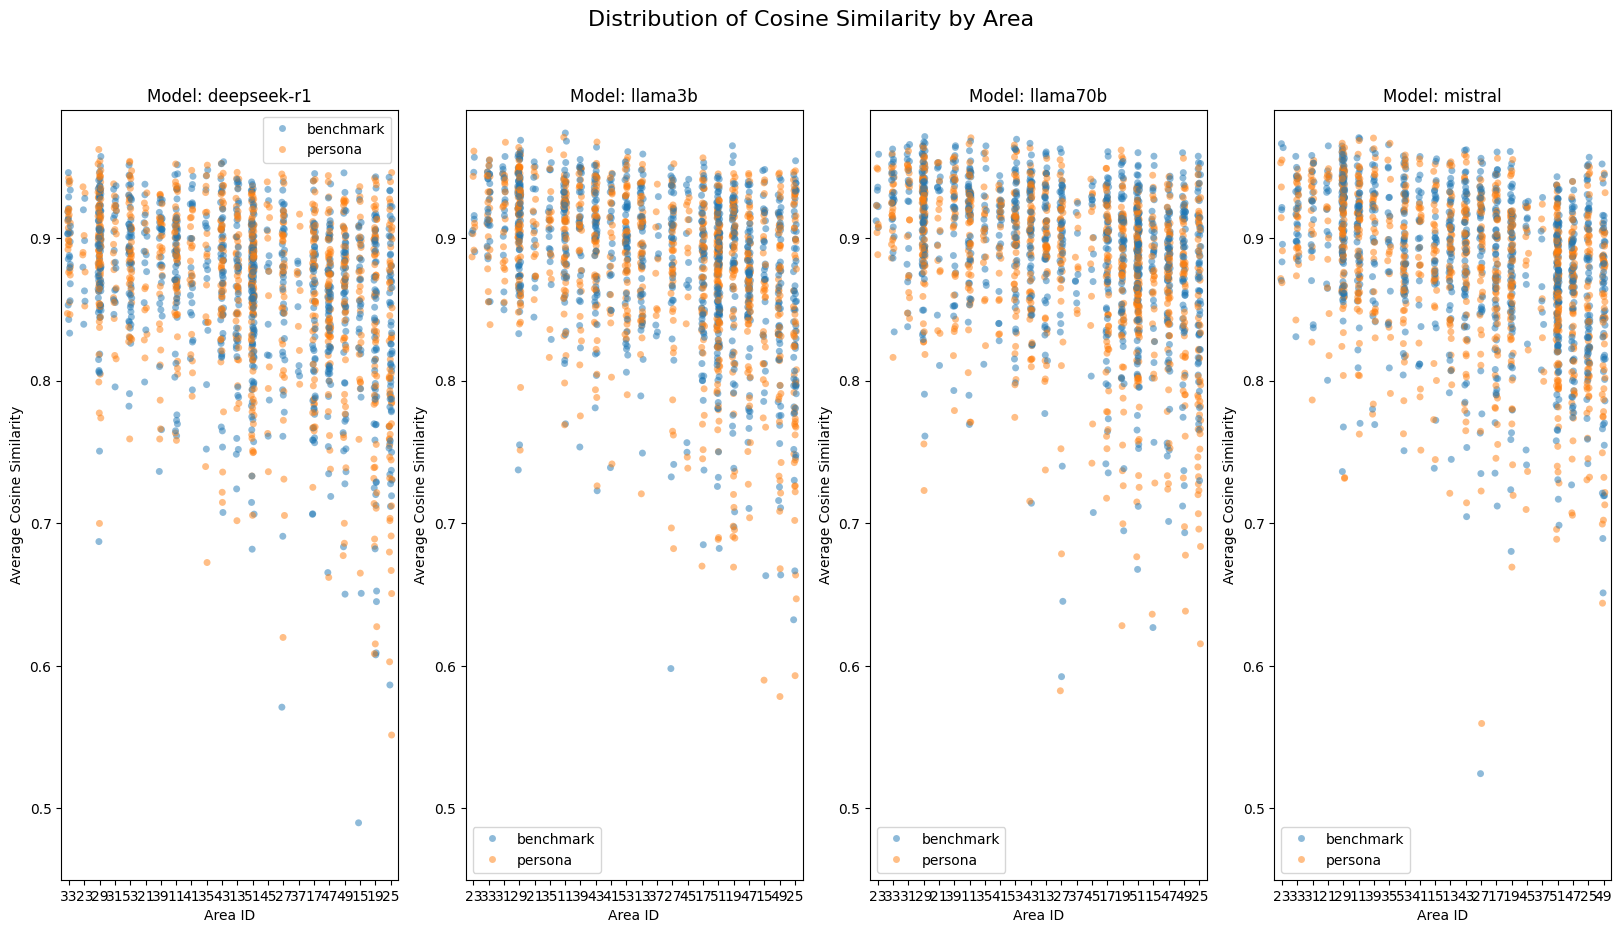

In [26]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 10))
plt.suptitle("Distribution of Cosine Similarity by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(1, 4, i)
    df_model = df_des[df_des['model'] == model].copy()

    df_diff = df_model.groupby('area')[['similarity']].mean()
    df_diff_sorted = df_diff.sort_values(by='similarity', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="similarity", hue="prompt", dodge=False, 
              size=5, alpha=0.5, jitter=True, order=df_diff_sorted)
    plt.title(f'Model: {model}')
    plt.xlabel('Area ID')
    plt.ylabel('Average Cosine Similarity')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0.45, .99)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])
plt.show()

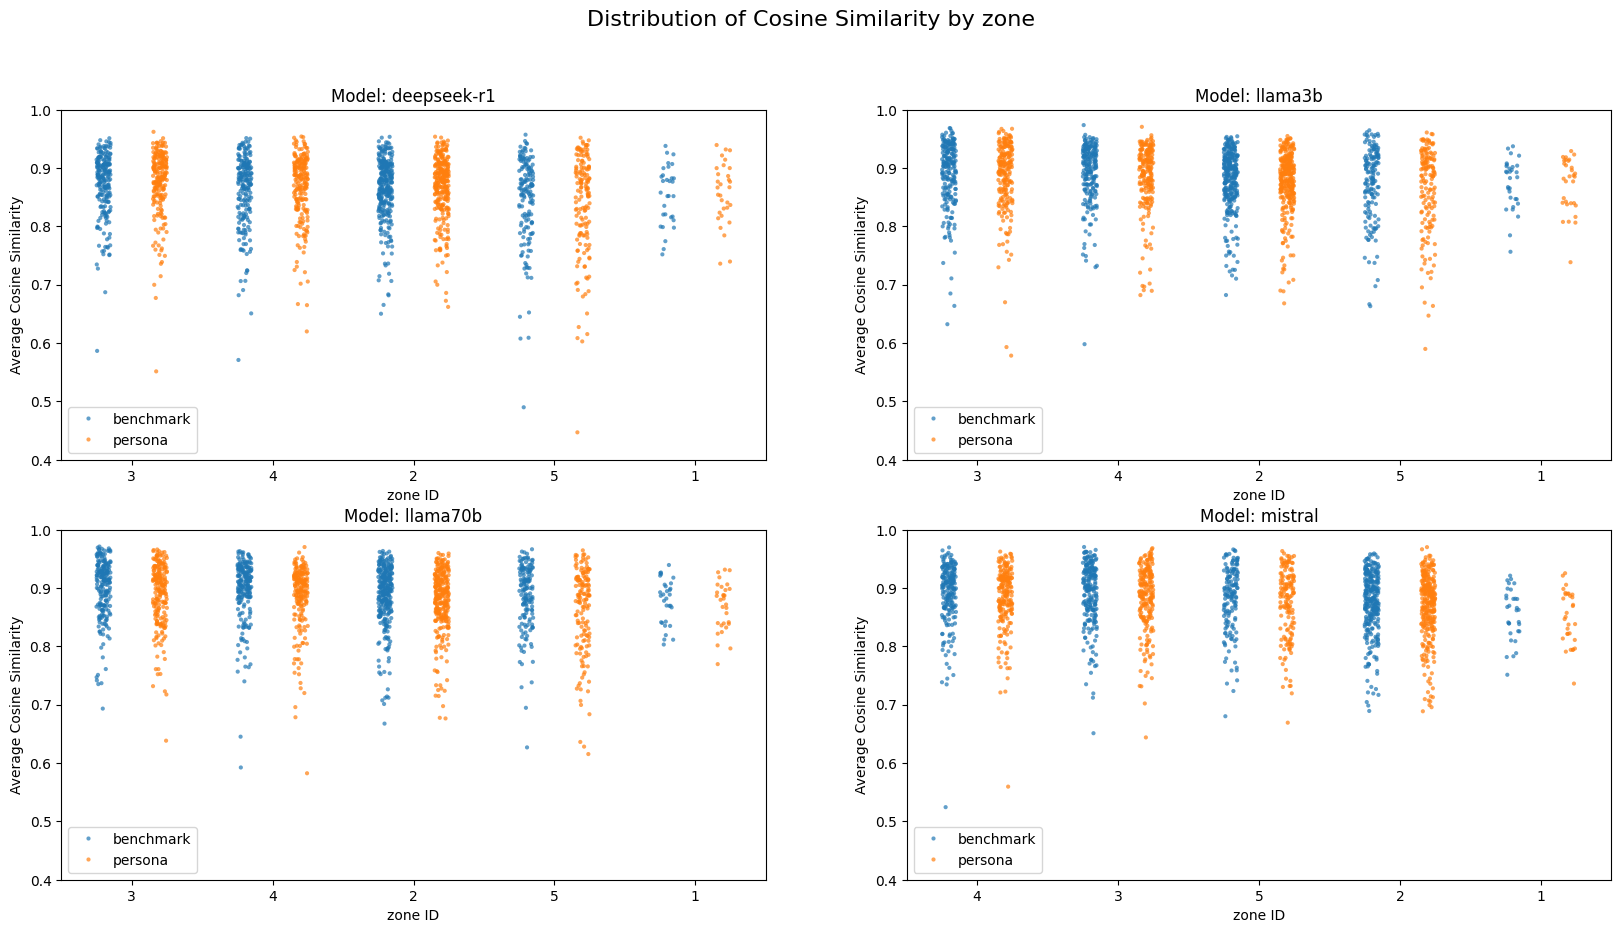

In [ ]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 10))
plt.suptitle("Distribution of Cosine Similarity by zone", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_des[df_des['model'] == model].copy()

    df_diff = df_model.groupby('zone')[['similarity']].median()
    df_diff_sorted = df_diff.sort_values(by='similarity', ascending=False).index
    sns.stripplot(data=df_model, x="zone", y="similarity", hue="prompt", dodge=True, 
              size=3, alpha=0.7, jitter=True, order=df_diff_sorted)
    plt.title(f'Model: {model}')
    plt.xlabel('zone ID')
    plt.ylabel('Average Cosine Similarity')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0.4,1)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])
plt.show()

In [ ]:
df_des_zone = df_des.pivot_table(index=["zone", "model"], columns=["prompt"], values="similarity").reset_index()
# df_des_zone = df_des_zone[df_des_zone['zone'] != 5]
df_des_zone["difference"] = (df_des_zone["persona"] - df_des_zone["benchmark"])
# add a column for % difference, format in percentage and 3 decimal places


df_des_zone["percent_difference"] = df_des_zone["difference"] / df_des_zone["benchmark"]
df_des_zone["percent_difference"] = df_des_zone["percent_difference"].apply(lambda x: f"{x:.3%}")


#restructure the DataFrame to have each 'model' a column
# df_des_zone = df_des_zone.pivot(index="zone", columns="model", values="difference").reset_index()
df_des_zone

prompt,zone,model,benchmark,persona,difference,percent_difference
0,1,deepseek-r1,0.853917,0.857094,0.003177,0.372%
1,1,llama3b,0.873025,0.870950,-0.002075,-0.238%
2,1,llama70b,0.877268,0.868517,-0.008751,-0.997%
3,1,mistral,0.854907,0.850056,-0.004851,-0.567%
4,2,deepseek-r1,0.863466,0.867715,0.004249,0.492%
5,2,llama3b,0.879418,0.875193,-0.004225,-0.480%
6,2,llama70b,0.886787,0.878553,-0.008234,-0.929%
7,2,mistral,0.874862,0.868535,-0.006327,-0.723%
8,3,deepseek-r1,0.871858,0.875621,0.003764,0.432%
9,3,llama3b,0.889976,0.886210,-0.003766,-0.423%


<Figure size 800x600 with 0 Axes>

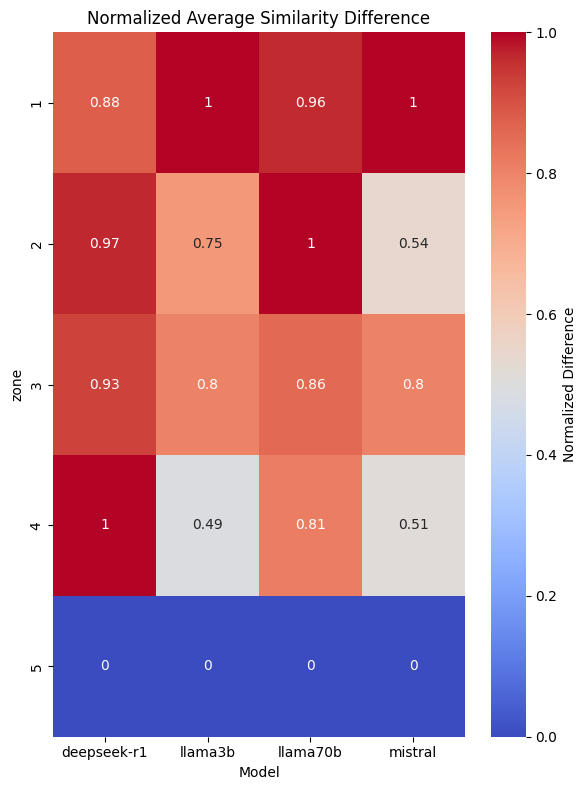

In [ ]:
df_des_zone = df_des.pivot_table(index=["zone", "model"], columns=["prompt"], values="similarity").reset_index()
# df_des_zone = df_des_zone[df_des_zone['zone'] != 5]
df_des_zone["difference"] = (df_des_zone["persona"] - df_des_zone["benchmark"])
df_des_zone["normalized_difference"] = df_des_zone.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

plt.figure(figsize=(8, 6))
# sns.barplot(data=df_des_zone, x="zone", y="normalized_difference", hue="model")
# Pivot the data so that rows are zone, columns are model, and values are normalized_difference
heatmap_data = df_des_zone.pivot(index="zone", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Similarity Difference")
plt.xlabel("Model")
plt.ylabel("zone")
plt.tight_layout()
plt.show()

In [ ]:
df_des_pivot = df_des.pivot_table(index=["area", "model"], columns=["prompt"], values="similarity").reset_index()
df_des_pivot["difference"] = (df_des_pivot["persona"] - df_des_pivot["benchmark"])
#restructure the DataFrame to have each 'model' a column
df_des_pivot = df_des_pivot.pivot(index="area", columns="model", values="difference").reset_index()
df_des_pivot

C:\Users\godfr\AppData\Local\Temp\ipykernel_7116\2651756552.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_des_pivot = df_des.pivot_table(index=["area", "model"], columns=["prompt"], values="similarity").reset_index()


model,area,deepseek-r1,llama3b,llama70b,mistral
0,11,0.004623,-0.003966,-0.008792,-0.007705
1,13,0.007778,-0.001118,-0.008335,-0.005720
2,15,-0.006592,-0.019987,-0.007938,-0.009301
3,17,0.009375,-0.000863,-0.011257,-0.004312
4,19,0.004183,-0.015460,-0.017763,-0.006547
5,21,-0.008901,-0.000607,-0.012607,-0.002603
6,23,0.013176,-0.003905,-0.008941,-0.004427
7,25,-0.019837,-0.017707,-0.041155,-0.014277
8,27,0.002502,-0.012391,-0.007247,-0.004751
9,29,0.005172,-0.000170,-0.007590,-0.002642


C:\Users\godfr\AppData\Local\Temp\ipykernel_7116\1646881137.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_des_pivot = df_des.pivot_table(index=["area", "model"], columns=["prompt"], values="similarity").reset_index()


<Figure size 800x600 with 0 Axes>

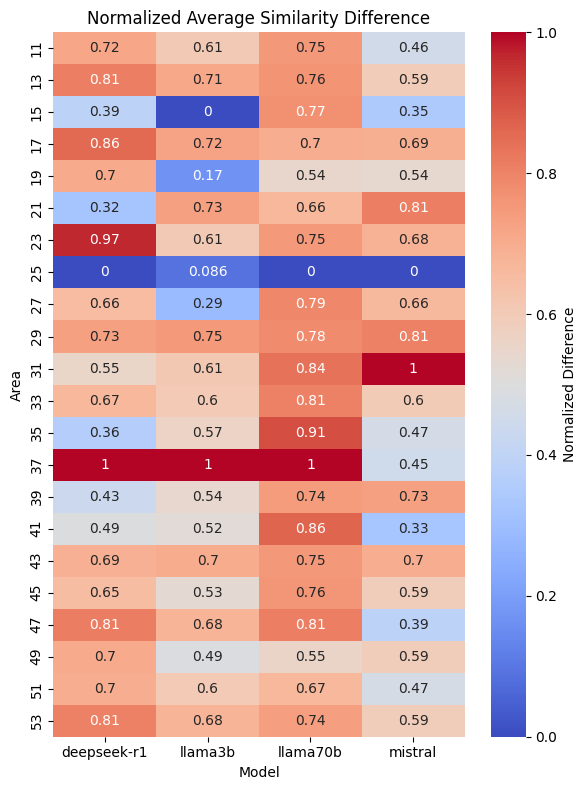

In [ ]:
df_des_pivot = df_des.pivot_table(index=["area", "model"], columns=["prompt"], values="similarity").reset_index()
# df_des_pivot = df_des_pivot[df_des_pivot['area'] != '25']
df_des_pivot["difference"] = (df_des_pivot["persona"] - df_des_pivot["benchmark"])
df_des_pivot["normalized_difference"] = df_des_pivot.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

plt.figure(figsize=(8, 6))
# sns.barplot(data=df_des_pivot, x="area", y="normalized_difference", hue="model")
# Pivot the data so that rows are area, columns are model, and values are normalized_difference
heatmap_data = df_des_pivot.pivot(index="area", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Similarity Difference")
plt.xlabel("Model")
plt.ylabel("Area")
plt.tight_layout()
plt.show()

### Compare Cosine distance

In [66]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# Define function to compute upper triangle from cosine similarity matrix
def compute_similarity_structure(df):
    codes = df['code'].unique()
    df = df.set_index('code').loc[codes]  # Ensure consistent ordering
    embeddings = np.stack(df['embedding'].values)
    cosine_sim = 1 - squareform(pdist(embeddings, metric='cosine'))
    upper_tri = cosine_sim[np.triu_indices_from(cosine_sim, k=1)]
    return upper_tri

# Extract unique models and prompts
models = df_all_embeddings['model'].unique()
prompts = ['ref', 'benchmark', 'persona']

# Store cosine similarity vectors
similarity_vectors = {}

# Loop through each iteration (assuming 0-9)
all_corrs = []
for iteration in range(10):
    similarity_vectors = {}
    # Filter for current iteration for benchmark/persona, and use ref (iteration doesn't matter for ref)
    for model in models:
        # Get reference embeddings (unique per code)
        df_ref = df_all_embeddings[(df_all_embeddings['model'] == model) & (df_all_embeddings['prompt'] == 'ref')].groupby(['model', 'prompt','code','area'])['embedding'].apply(lambda x: np.mean(np.stack(x), axis=0)).reset_index()
        sim_vec_ref = compute_similarity_structure(df_ref)
        similarity_vectors[(model, 'ref')] = sim_vec_ref

        for prompt in ['benchmark', 'persona']:
            df_sub = df_all_embeddings[
                (df_all_embeddings['model'] == model) &
                (df_all_embeddings['prompt'] == prompt) &
                (df_all_embeddings['iteration'] == iteration)
            ]
            sim_vec = compute_similarity_structure(df_sub)
            similarity_vectors[(model, prompt)] = sim_vec

    # Compare each model's benchmark/persona to ref for this iteration
    for model in models:
        ref_vec = similarity_vectors[(model, 'ref')]
        for other_prompt in ['benchmark', 'persona']:
            other_vec = similarity_vectors[(model, other_prompt)]
            rho, pval = spearmanr(ref_vec, other_vec)
            all_corrs.append({
                'iteration': iteration,
                'model': model,
                'comparison': other_prompt,
                'spearman_rho': rho,
                'p_value': pval
            })

# Output results
corr_df = pd.DataFrame(all_corrs)
corr_df


,iteration,model,comparison,spearman_rho,p_value
0,0,deepseek-r1,benchmark,0.025176,3.775816e-55
1,0,deepseek-r1,persona,0.008602,9.100821e-08
2,0,llama3b,benchmark,0.024351,1.041841e-51
3,0,llama3b,persona,0.014985,1.293285e-20
4,0,llama70b,benchmark,0.031633,5.233846e-86
...,...,...,...,...,...
75,9,llama3b,persona,0.020356,1.177283e-36
76,9,llama70b,benchmark,0.018911,7.174392e-32
77,9,llama70b,persona,0.016440,1.733762e-24
78,9,mistral,benchmark,0.016318,3.762952e-24


In [67]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# Define function to compute upper triangle from cosine similarity matrix
def compute_similarity_structure(df):
    codes = df['code'].unique()
    df = df.set_index('code').loc[codes]  # Ensure consistent ordering
    embeddings = np.stack(df['embedding'].values)
    cosine_sim = 1 - squareform(pdist(embeddings, metric='cosine'))
    upper_tri = cosine_sim[np.triu_indices_from(cosine_sim, k=1)]
    return upper_tri

# Extract unique models and prompts
models = df_all_embeddings_avg['model'].unique()
prompts = ['ref', 'benchmark', 'persona']

# Store cosine similarity vectors
similarity_vectors = {}

# Loop through each iteration (assuming 0-9)
all_corrs = []
for iteration in range(1):
    similarity_vectors = {}
    # Filter for current iteration for benchmark/persona, and use ref (iteration doesn't matter for ref)
    for model in models:
        # Get reference embeddings (unique per code)
        df_ref = df_all_embeddings_avg[(df_all_embeddings_avg['model'] == model) & (df_all_embeddings_avg['prompt'] == 'ref')].groupby(['model', 'prompt','code'])['embedding'].apply(lambda x: np.mean(np.stack(x), axis=0)).reset_index()
        sim_vec_ref = compute_similarity_structure(df_ref)
        similarity_vectors[(model, 'ref')] = sim_vec_ref

        for prompt in ['benchmark', 'persona']:
            df_sub = df_all_embeddings_avg[
                (df_all_embeddings_avg['model'] == model) &
                (df_all_embeddings_avg['prompt'] == prompt)
            ]
            sim_vec = compute_similarity_structure(df_sub)
            similarity_vectors[(model, prompt)] = sim_vec

    # Compare each model's benchmark/persona to ref for this iteration
    for model in models:
        ref_vec = similarity_vectors[(model, 'ref')]
        for other_prompt in ['benchmark', 'persona']:
            other_vec = similarity_vectors[(model, other_prompt)]
            rho, pval = spearmanr(ref_vec, other_vec)
            all_corrs.append({
                'iteration': iteration,
                'model': model,
                'comparison': other_prompt,
                'spearman_rho': rho,
                'p_value': pval
            })

# Output results
corr_df_avg = pd.DataFrame(all_corrs)
corr_df_avg



,iteration,model,comparison,spearman_rho,p_value
0,0,deepseek-r1,benchmark,0.681611,0.0
1,0,deepseek-r1,persona,0.697797,0.0
2,0,llama3b,benchmark,0.741339,0.0
3,0,llama3b,persona,0.733426,0.0
4,0,llama70b,benchmark,0.757873,0.0
5,0,llama70b,persona,0.733498,0.0
6,0,mistral,benchmark,0.743357,0.0
7,0,mistral,persona,0.733024,0.0


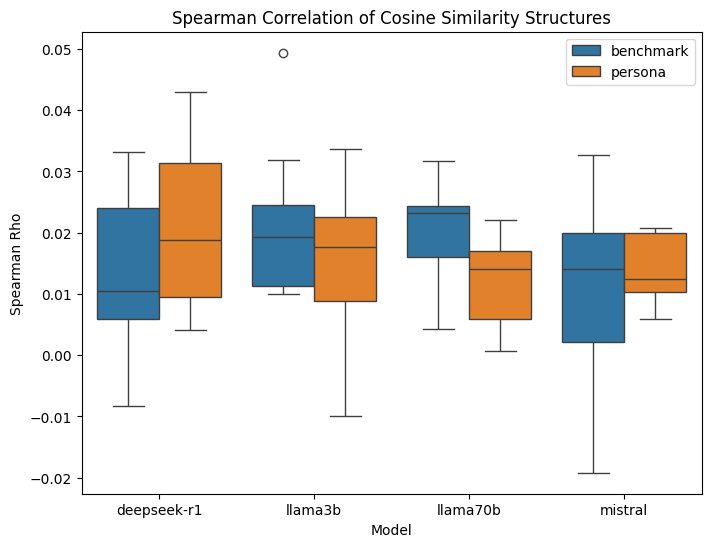

In [68]:
corr_df
# Plotting the Spearman correlation
plt.figure(figsize=(8, 6))
sns.boxplot(data=corr_df, x='model', y='spearman_rho', hue='comparison')
plt.title('Spearman Correlation of Cosine Similarity Structures')
plt.xlabel('Model')
plt.ylabel('Spearman Rho')
plt.legend()

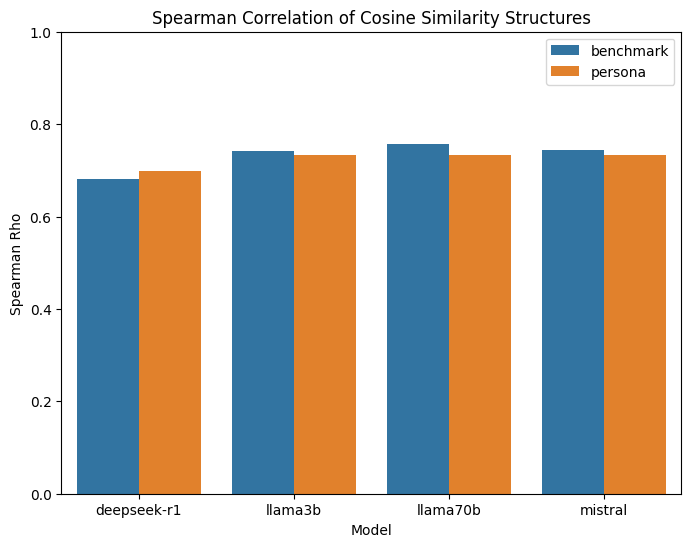

In [71]:
corr_df_avg
# Plotting the Spearman correlation
plt.figure(figsize=(8, 6))
sns.barplot(data=corr_df_avg, x='model', y='spearman_rho', hue='comparison')
plt.title('Spearman Correlation of Cosine Similarity Structures')
plt.xlabel('Model')
plt.ylabel('Spearman Rho')
plt.ylim(0, 1)
plt.legend()

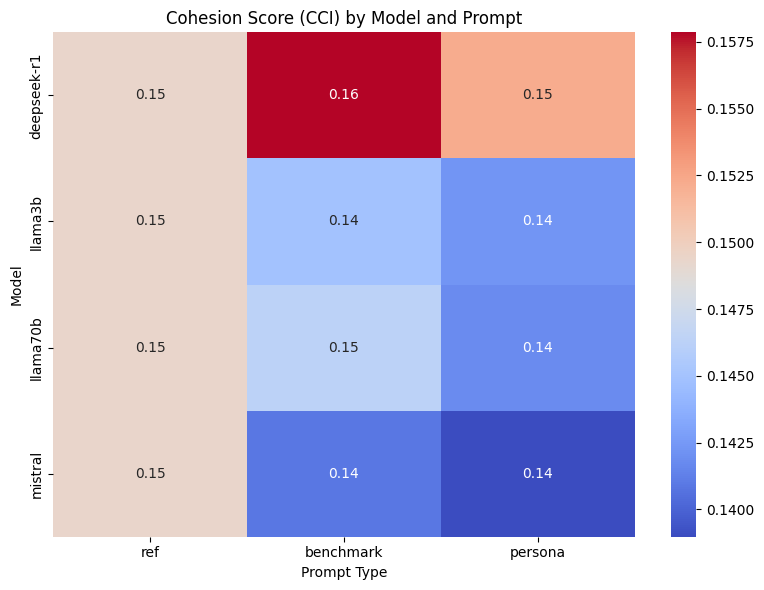

In [75]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Convert embedding column to np.array
df_all_embeddings_avg['embedding'] = df_all_embeddings_avg['embedding'].apply(lambda x: np.array(x))

def compute_cohesion_score(embeddings, labels):
    """
    Compute CCI: mean inter-area distance - mean intra-area distance
    """
    distances = cosine_distances(embeddings)
    n = len(labels)

    intra_dists, inter_dists = [], []

    for i in range(n):
        for j in range(i + 1, n):
            if labels[i] == labels[j]:
                intra_dists.append(distances[i, j])
            else:
                inter_dists.append(distances[i, j])

    return np.mean(inter_dists) - np.mean(intra_dists)

# Create empty list to store results
results = []

# Loop over models and prompts
for model in df_all_embeddings_avg['model'].unique():
    for prompt in ['ref', 'benchmark', 'persona']:
        subset = df_all_embeddings_avg[(df_all_embeddings_avg['model'] == model) & (df_all_embeddings_avg['prompt'] == prompt)]
        embeddings = np.stack(subset['embedding'].values)
        labels = subset['area'].values
        cohesion_score = compute_cohesion_score(embeddings, labels)
        results.append({
            'model': model,
            'prompt': prompt,
            'cohesion_score': cohesion_score
        })

# Convert results to DataFrame
cohesion_df = pd.DataFrame(results)

# Pivot for heatmap
pivot = cohesion_df.pivot(index='model', columns='prompt', values='cohesion_score')

# Sort prompts in desired order
pivot = pivot[['ref', 'benchmark', 'persona']]

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Cohesion Score (CCI) by Model and Prompt")
plt.ylabel("Model")
plt.xlabel("Prompt Type")
plt.tight_layout()
plt.show()


In [76]:
cohesion_df

,model,prompt,cohesion_score
0,deepseek-r1,ref,0.149333
1,deepseek-r1,benchmark,0.157857
2,deepseek-r1,persona,0.152230
3,llama3b,ref,0.149333
4,llama3b,benchmark,0.144916
5,llama3b,persona,0.142271
6,llama70b,ref,0.149333
7,llama70b,benchmark,0.146346
8,llama70b,persona,0.141799
9,mistral,ref,0.149333


In [98]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

def cosine_clustering_index(df, label_col='area'):
    """
    Calculate the Cosine Clustering Index (CCI) for clustered embeddings.
    
    Args:
        df (pd.DataFrame): Must contain 'embedding' (vector) and cluster label column.
        label_col (str): Column used as cluster label (e.g., 'area' or 'job_area').

    Returns:
        float: CCI score (higher = better cohesion)
        dict: Per-cluster cohesion scores
    """
    cluster_labels = df[label_col].unique()
    cluster_scores = {}
    
    for cluster in cluster_labels:
        cluster_data = df[df[label_col] == cluster]
        embeddings = np.stack(cluster_data['embedding'].values)

        if len(embeddings) < 2:
            cluster_scores[cluster] = np.nan  # skip singleton clusters
            continue

        # Cosine distance: pdist returns pairwise distances
        cosine_dists = pdist(embeddings, metric='cosine')
        avg_cosine_distance = np.mean(cosine_dists)

        # Convert to cohesion (1 - average distance)
        cohesion_score = 1- avg_cosine_distance
        cluster_scores[cluster] = cohesion_score

    # Mean over clusters (ignore NaNs from singleton clusters)
    valid_scores = [v for v in cluster_scores.values() if not np.isnan(v)]
    cci_score = np.mean(valid_scores)
    
    return cci_score, cluster_scores


In [100]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

def cosine_clustering_index(X, labels):
    """
    Compute Cosine Clustering Index (CCI).

    Args:
        X (np.ndarray): Data matrix (n_samples x n_features).
        labels (array-like): Cluster labels for each data point.

    Returns:
        float: CCI value between 0 and 1 (higher is better).
    """
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    k = len(unique_labels)
    if k < 2:
        # Can't compute inter-cluster separation with fewer than 2 clusters
        return np.nan

    # Compute centroids of each cluster
    centroids = np.array([X[labels == lbl].mean(axis=0) for lbl in unique_labels])

    # Compute intra-cluster cohesion (C): sum of cosine distances of points to their cluster centroid
    C = 0
    for lbl in unique_labels:
        cluster_points = X[labels == lbl]
        centroid = cluster_points.mean(axis=0, keepdims=True)
        distances = cosine_distances(cluster_points, centroid).flatten()
        C += distances.sum()

    # Compute inter-cluster separation (S): sum of cosine distances between cluster centroids (upper triangle)
    centroid_distances = cosine_distances(centroids)
    S = centroid_distances[np.triu_indices(k, k=1)].sum()

    # Calculate CCI as S / (C + S), with a safeguard for zero division
    CCI = S / (C + S) if (C + S) > 0 else 0
    return CCI


In [102]:
results = []
for model in df_all_embeddings_avg['model'].unique():
    for prompt in ['ref', 'benchmark', 'persona']:
        sub_df = df_all_embeddings_avg[(df_all_embeddings_avg['model'] == model) & (df_all_embeddings_avg['prompt'] == prompt)]
        embeddings = np.vstack(sub_df['embedding'].values)
        labels = sub_df['area'].values
        
        cci = cosine_clustering_index(embeddings, labels)
        results.append({'model': model, 'prompt': prompt, 'CCI': cci})

cci_df = pd.DataFrame(results)
print(cci_df)


          model     prompt       CCI
0   deepseek-r1        ref  0.242158
1   deepseek-r1  benchmark  0.251376
2   deepseek-r1    persona  0.249085
3       llama3b        ref  0.242158
4       llama3b  benchmark  0.248482
5       llama3b    persona  0.243980
6      llama70b        ref  0.242158
7      llama70b  benchmark  0.247209
8      llama70b    persona  0.240752
9       mistral        ref  0.242158
10      mistral  benchmark  0.242405
11      mistral    persona  0.239949


In [103]:
def per_cluster_cohesion(X, labels):
    """
    Compute average intra-cluster cohesion (cosine distance to centroid) for each cluster.

    Args:
        X (np.ndarray): Data matrix (n_samples x n_features).
        labels (array-like): Cluster labels.

    Returns:
        dict: cluster_id -> average intra-cluster distance
    """
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    cohesion = {}

    for lbl in unique_labels:
        cluster_points = X[labels == lbl]
        centroid = cluster_points.mean(axis=0, keepdims=True)
        distances = cosine_distances(cluster_points, centroid).flatten()
        cohesion[lbl] = distances.mean()  # or .sum() if you prefer total cohesion

    return cohesion

In [105]:
results = []

for model in df_all_embeddings['model'].unique():
    for prompt in ['ref', 'benchmark', 'persona']:
        sub_df = df_all_embeddings[(df_all_embeddings['model'] == model) & (df_all_embeddings['prompt'] == prompt)]
        X = np.vstack(sub_df['embedding'].values)
        labels = sub_df['area'].values

        cohesion_scores = per_cluster_cohesion(X, labels)
        for area, cohesion in cohesion_scores.items():
            results.append({
                'model': model,
                'prompt': prompt,
                'area': area,
                'cohesion': cohesion
            })

df_cluster_cohesion = pd.DataFrame(results)


In [108]:
merged

,model,prompt,area,cohesion,ref_cohesion,cohesion_diff
0,deepseek-r1,ref,11,0.239170,0.239170,0.000000
1,deepseek-r1,ref,13,0.288843,0.288843,0.000000
2,deepseek-r1,ref,15,0.227848,0.227848,0.000000
3,deepseek-r1,ref,17,0.259697,0.259697,0.000000
4,deepseek-r1,ref,19,0.296654,0.296654,0.000000
...,...,...,...,...,...,...
259,mistral,persona,45,0.204042,0.224861,-0.020818
260,mistral,persona,47,0.250744,0.282053,-0.031309
261,mistral,persona,49,0.222467,0.217033,0.005434
262,mistral,persona,51,0.237894,0.244120,-0.006225


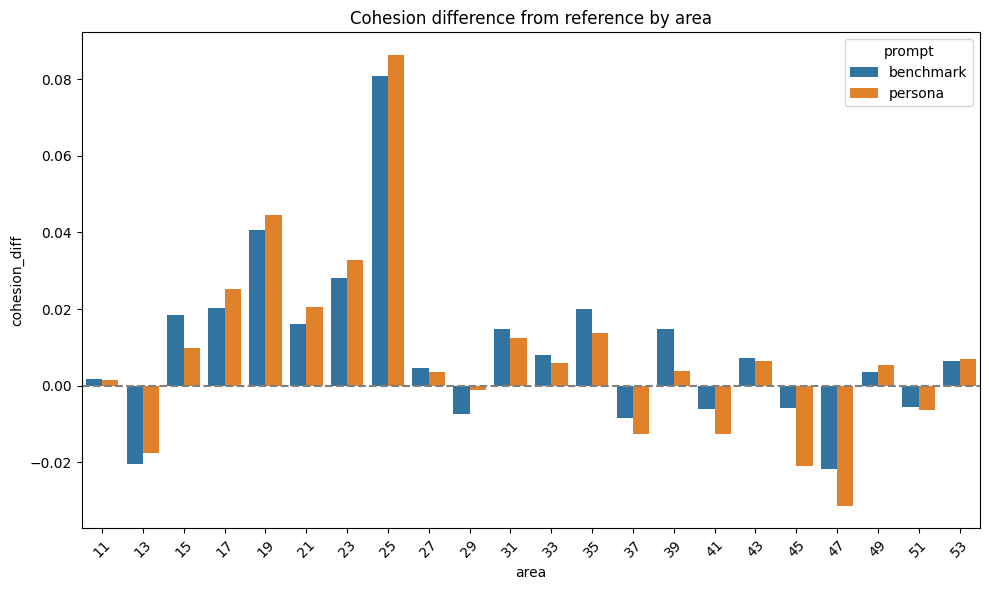

In [110]:
# Normalize ref to 0
ref_scores = df_cluster_cohesion[df_cluster_cohesion['prompt'] == 'ref'].rename(columns={'cohesion': 'ref_cohesion'})
merged = df_cluster_cohesion.merge(ref_scores[['model', 'area', 'ref_cohesion']], on=['model', 'area'])
merged['cohesion_diff'] = merged['cohesion'] - merged['ref_cohesion']
merged = merged[merged['model'] == 'mistral']
# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=merged[merged['prompt'] != 'ref'], x='area', y='cohesion_diff', hue='prompt')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Cohesion difference from reference by area")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [99]:
# Example usage
for model in df_all_embeddings_avg['model'].unique():
    for prompt in ['ref', 'benchmark', 'persona']:
        df_all_embeddings_avg_subset = df_all_embeddings_avg[(df_all_embeddings_avg['model'] == model) & (df_all_embeddings_avg['prompt'] == prompt)]
        cci_score, per_area_scores = cosine_clustering_index(df_all_embeddings_avg_subset, label_col='area')
        print(f"Model: {model}, Prompt: {prompt}, CCI: {cci_score:.4f}")


Model: deepseek-r1, Prompt: ref, CCI: 0.5970
Model: deepseek-r1, Prompt: benchmark, CCI: 0.5989
Model: deepseek-r1, Prompt: persona, CCI: 0.5976
Model: llama3b, Prompt: ref, CCI: 0.5970
Model: llama3b, Prompt: benchmark, CCI: 0.6178
Model: llama3b, Prompt: persona, CCI: 0.6147
Model: llama70b, Prompt: ref, CCI: 0.5970
Model: llama70b, Prompt: benchmark, CCI: 0.6191
Model: llama70b, Prompt: persona, CCI: 0.6065
Model: mistral, Prompt: ref, CCI: 0.5970
Model: mistral, Prompt: benchmark, CCI: 0.6223
Model: mistral, Prompt: persona, CCI: 0.6221


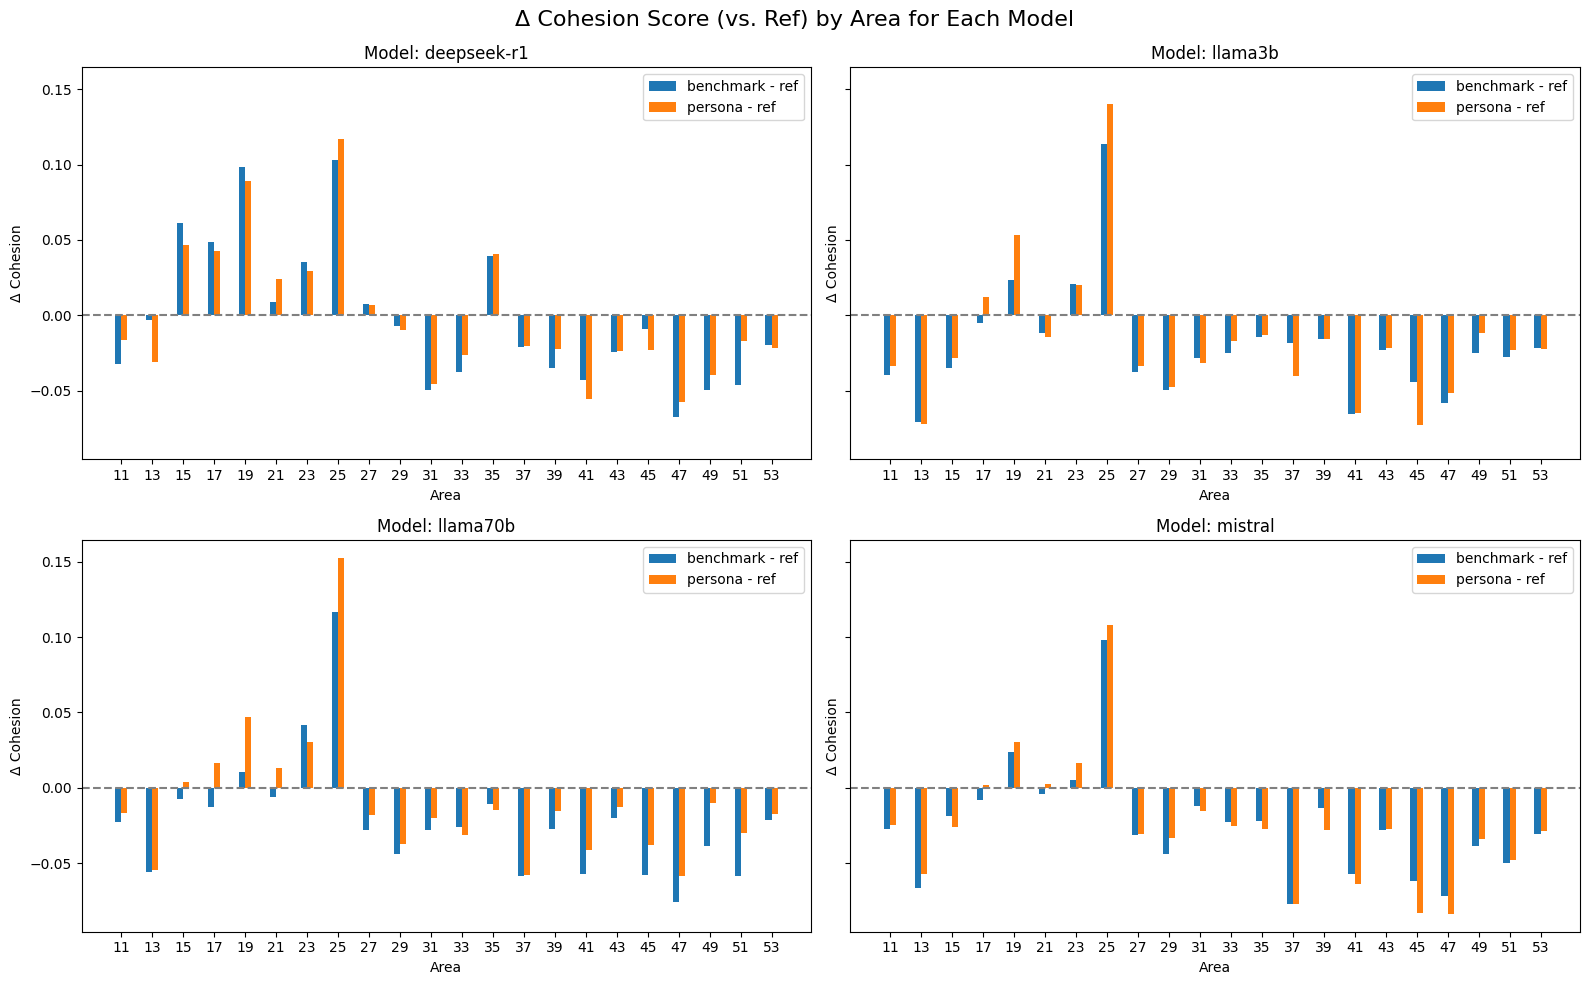

In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt

# --- Cohesion computation ---
def compute_intra_area_cohesion(embeddings):
    distances = cosine_distances(embeddings)
    n = len(embeddings)
    return np.sum(distances) / (n * (n - 1)) if n > 1 else np.nan

# --- Calculate cohesion scores ---
area_scores = []
for model in df_all_embeddings_avg['model'].unique():
    for prompt in ['ref', 'benchmark', 'persona']:
        df_sub = df_all_embeddings_avg[(df_all_embeddings_avg['model'] == model) & (df_all_embeddings_avg['prompt'] == prompt)]
        for area in df_sub['area'].unique():
            df_area = df_sub[df_sub['area'] == area]
            if len(df_area) > 1:
                embeddings = np.stack(df_area['embedding'].values)
                cohesion = compute_intra_area_cohesion(embeddings)
                area_scores.append({
                    'model': model,
                    'prompt': prompt,
                    'area': area,
                    'cohesion': cohesion
                })

area_df = pd.DataFrame(area_scores)

# --- Pivot & delta calculation ---
pivot_df = area_df.pivot_table(index=['model', 'area'], columns='prompt', values='cohesion')
pivot_df['delta_benchmark'] = pivot_df['benchmark'] - pivot_df['ref']
pivot_df['delta_persona'] = pivot_df['persona'] - pivot_df['ref']
pivot_df = pivot_df.reset_index()

# --- Plot with subplots 2x2 ---
models = df['model'].unique()
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
axs = axs.flatten()

for i, model in enumerate(models):
    model_df = pivot_df[pivot_df['model'] == model]
    # Convert area to numeric for plotting
    x = pd.to_numeric(model_df['area'])
    axs[i].bar(x - 0.2, model_df['delta_benchmark'], width=0.4, label='benchmark - ref', color='tab:blue')
    axs[i].bar(x + 0.2, model_df['delta_persona'], width=0.4, label='persona - ref', color='tab:orange')
    axs[i].axhline(0, ls='--', color='gray')
    axs[i].set_title(f"Model: {model}")
    axs[i].set_xlabel("Area")
    axs[i].set_ylabel("Δ Cohesion")
    axs[i].legend()
    # Set xticks and labels as numeric, but display as string for clarity
    xticks = pd.to_numeric(sorted(df['area'].unique()))
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(sorted(df['area'].unique()))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Δ Cohesion Score (vs. Ref) by Area for Each Model", fontsize=16)
plt.show()


In [ ]:
model_df

prompt,model,area,benchmark,persona,ref,delta_benchmark,delta_persona
0,deepseek-r1,11,0.397477,0.412931,0.429560,-0.032083,-0.016629
1,deepseek-r1,13,0.503239,0.475259,0.506024,-0.002785,-0.030765
2,deepseek-r1,15,0.479574,0.464978,0.418202,0.061372,0.046776
3,deepseek-r1,17,0.508936,0.502976,0.460320,0.048615,0.042656
4,deepseek-r1,19,0.612188,0.603005,0.514017,0.098171,0.088988
5,deepseek-r1,21,0.328312,0.343476,0.319437,0.008875,0.024040
6,deepseek-r1,23,0.290909,0.284629,0.255410,0.035499,0.029219
7,deepseek-r1,25,0.347899,0.362098,0.244987,0.102912,0.117111
8,deepseek-r1,27,0.502871,0.502071,0.495010,0.007861,0.007061
9,deepseek-r1,29,0.440993,0.438946,0.448340,-0.007347,-0.009393


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm

def compute_area_cohesion(df_subset):
    # Sort for reproducibility
    df_sorted = df_subset.sort_values(by='code')
    X = np.vstack(df_sorted['embedding'].values)
    areas = df_sorted['area'].values

    # Compute cosine distance matrix
    D = cosine_distances(X)
    
    intra_dists = []
    inter_dists = []

    for i in range(len(areas)):
        for j in range(i + 1, len(areas)):
            if areas[i] == areas[j]:
                intra_dists.append(D[i, j])
            else:
                inter_dists.append(D[i, j])

    return {
        "intra_area_mean": np.mean(intra_dists),
        "inter_area_mean": np.mean(inter_dists),
        "cohesion_score": np.mean(inter_dists) - np.mean(intra_dists)
    }


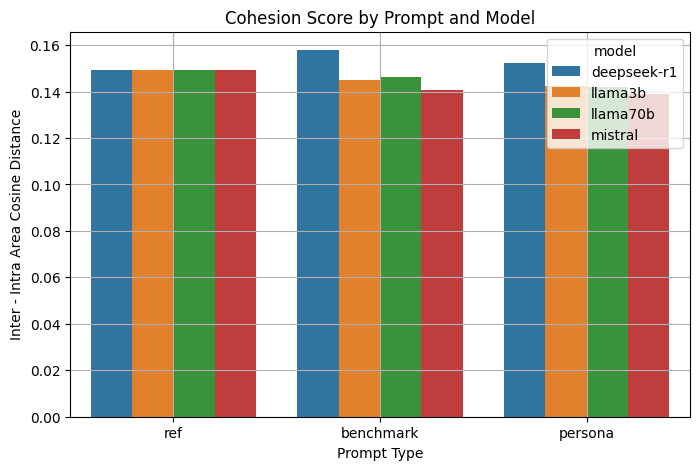

In [ ]:
results = []

for model in df_all_embeddings['model'].unique():
    for prompt in df_all_embeddings['prompt'].unique():
        subset = df_all_embeddings[(df_all_embeddings['model'] == model) & (df_all_embeddings['prompt'] == prompt)]
        if subset.empty:
            continue
        metrics = compute_area_cohesion(subset)
        metrics.update({"model": model, "prompt": prompt})
        results.append(metrics)

df_results = pd.DataFrame(results)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=df_results, x='prompt', y='cohesion_score', hue='model')
plt.title('Cohesion Score by Prompt and Model')
plt.ylabel('Inter - Intra Area Cosine Distance')
plt.xlabel('Prompt Type')
plt.grid(True)
plt.show()



### Clustering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import umap

df_clus = df[df["model"] == "mistral"].copy()

# --- 1. Prepare All Normalized Embeddings ---

# Get unique reference embeddings (one per code)
# Ensure no duplicates if code appears multiple times but ref_embeddings are identical.
ref_embeddings_df = df_clus.drop_duplicates(subset=['code']).set_index('code')
ref_embs_list = np.stack(ref_embeddings_df['ref_embeddings'].values)
ref_embs_norm = normalize(ref_embs_list)

# Get ALL generated embeddings (10 per code for each prompt type)
all_bench_embs = np.stack(df_clus[df_clus['prompt'] == 'benchmark']['gen_embeddings'].values)
all_pers_embs = np.stack(df_clus[df_clus['prompt'] == 'persona']['gen_embeddings'].values)

# Normalize all generated embeddings
all_bench_embs_norm = normalize(all_bench_embs)
all_pers_embs_norm = normalize(all_pers_embs)

print(f"Shape of normalized Ref embeddings: {ref_embs_norm.shape}")
print(f"Shape of normalized ALL Benchmark embeddings: {all_bench_embs_norm.shape}")
print(f"Shape of normalized ALL Persona embeddings: {all_pers_embs_norm.shape}")
print("-" * 30)

# reduce dimensionality of the embeddings using UMAP
n_components = 15
k_clusters = 50 # You can experiment with different k values
reducer = umap.UMAP(n_components=n_components,
                     n_neighbors=15, # Tune this
                     min_dist=0,   # Tune this
                     metric='cosine', # Or 'euclidean' if preferred, but cosine is good for normalized vecs
                     random_state=42)

# Fit UMAP ONLY on the Reference embeddings (gold standard)
print("Fitting UMAP on Reference embeddings...")
reducer.fit(ref_embs_norm)
print("UMAP fitting complete.")

# Transform all sets of embeddings using the fitted UMAP model
ref_embs_reduced = reducer.transform(ref_embs_norm)
all_bench_embs_reduced = reducer.transform(all_bench_embs_norm)
all_pers_embs_reduced = reducer.transform(all_pers_embs_norm)

# --- 2. Define Reference Clusters (Gold Standard) ---
# Choose k, the number of clusters. This defines the granularity of your semantic groups.
# A common starting point is sqrt(N) or based on domain knowledge.
# For 879 jobs, k=50 or k=100 might be reasonable.


# Initialize KMeans. Using random_state for reproducibility.
# n_init='auto' (default in recent scikit-learn) or n_init=10
# For cosine similarity with KMeans, ensure vectors are L2-normalized beforehand.
kmeans_ref = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')

# Fit KMeans on the Reference embeddings
kmeans_ref.fit(ref_embs_reduced)
ref_cluster_labels = kmeans_ref.labels_

print(f"KMeans fitted on Reference data with k={k_clusters} clusters.")
print("-" * 30)


# --- 3. Map Job Codes to Reference Clusters ---
# Create a mapping from code to its cluster label
code_to_ref_cluster = {}
for i, code in enumerate(ref_embeddings_df.index):
    code_to_ref_cluster[code] = ref_cluster_labels[i]

print("Job codes mapped to their Reference cluster labels.")
print("-" * 30)


# --- 4. Create "Ground Truth" Labels for Generated Data ---
# These are the "true" cluster labels for each generated embedding,
# based on which Reference cluster its code belongs to.

true_labels_bench = []
for code in df_clus[df_clus['prompt'] == 'benchmark']['code']:
    true_labels_bench.append(code_to_ref_cluster[code])

true_labels_pers = []
for code in df_clus[df_clus['prompt'] == 'persona']['code']:
    true_labels_pers.append(code_to_ref_cluster[code])

true_labels_bench = np.array(true_labels_bench)
true_labels_pers = np.array(true_labels_pers)

print(f"Shape of ground truth labels for Benchmark: {true_labels_bench.shape}")
print(f"Shape of ground truth labels for Persona: {true_labels_pers.shape}")
print("-" * 30)


# --- 5. Predict Clusters for Generated Data (using Reference KMeans Model) ---
# We use the *same* KMeans model that was fitted on the Reference data
# to predict where the generated embeddings would fall within those defined clusters.

predicted_labels_bench = kmeans_ref.predict(all_bench_embs_reduced)
predicted_labels_pers = kmeans_ref.predict(all_pers_embs_reduced)

print("Predicted cluster labels for generated data.")
print("-" * 30)


# --- 6. Calculate Adjusted Rand Index (ARI) ---
# ARI measures the similarity of the two assignments,
# ignoring permutations and chance agreement.
# A score of 1.0 means perfect match. A score near 0 means random assignment.

ari_bench = adjusted_rand_score(true_labels_bench, predicted_labels_bench)
ari_pers = adjusted_rand_score(true_labels_pers, predicted_labels_pers)

print(f"Adjusted Rand Index (ARI) for Benchmark vs Reference structure: {ari_bench:.4f}")
print(f"Adjusted Rand Index (ARI) for Persona vs Reference structure: {ari_pers:.4f}")
print("-" * 30)


# --- 7. Compare ARI Scores ---
if ari_pers > ari_bench:
    print(f"Persona embeddings ({ari_pers:.4f}) show HIGHER structural alignment with Reference "
          f"than Benchmark embeddings ({ari_bench:.4f}).")
    print(f"This suggests Persona better preserves the semantic grouping structure defined by the Reference data at k={k_clusters}.")
elif ari_pers < ari_bench:
    print(f"Persona embeddings ({ari_pers:.4f}) show LOWER structural alignment with Reference "
          f"than Benchmark embeddings ({ari_bench:.4f}).")
    print(f"This suggests Benchmark better preserves the semantic grouping structure at k={k_clusters}.")
else:
    print(f"Persona and Benchmark embeddings show SIMILAR structural alignment with Reference at k={k_clusters}.")

Shape of normalized Ref embeddings: (879, 768)
Shape of normalized ALL Benchmark embeddings: (8790, 768)
Shape of normalized ALL Persona embeddings: (8790, 768)
------------------------------
Fitting UMAP on Reference embeddings...


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP fitting complete.
KMeans fitted on Reference data with k=50 clusters.
------------------------------
Job codes mapped to their Reference cluster labels.
------------------------------
Shape of ground truth labels for Benchmark: (8790,)
Shape of ground truth labels for Persona: (8790,)
------------------------------
Predicted cluster labels for generated data.
------------------------------
Adjusted Rand Index (ARI) for Benchmark vs Reference structure: 0.6668
Adjusted Rand Index (ARI) for Persona vs Reference structure: 0.6611
------------------------------
Persona embeddings (0.6611) show LOWER structural alignment with Reference than Benchmark embeddings (0.6668).
This suggests Benchmark better preserves the semantic grouping structure at k=50.


Fitting UMAP on Reference embeddings...


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP fitting complete.
Shape of UMAP-reduced Ref embeddings: (879, 30)
------------------------------
Finding optimal k for Reference Embeddings...

Optimal k by Silhouette Score: 28 (Score: 0.3556)
------------------------------


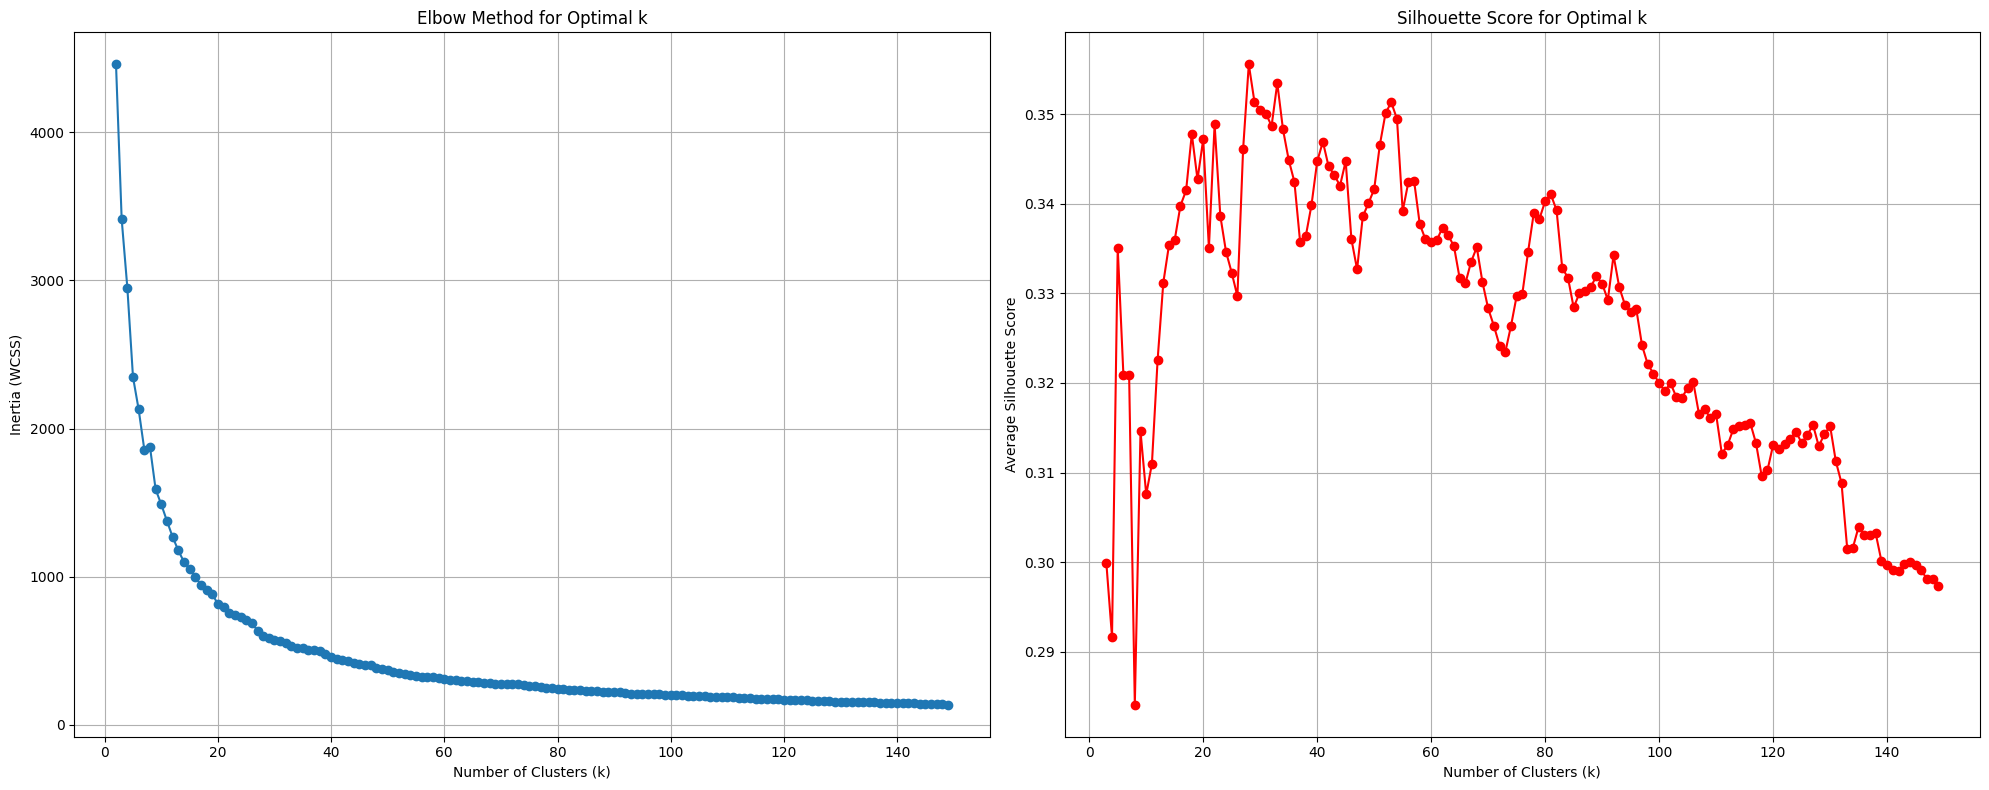

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score # Import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA # Import PCA
import umap # Import UMAP

# --- 1. Prepare All Normalized Embeddings ---
ref_embeddings_df = df_clus.drop_duplicates(subset=['code']).set_index('code')
ref_embs_list = np.stack(ref_embeddings_df['ref_embeddings'].values)
ref_embs_norm = normalize(ref_embs_list)

# # --- 2. Perform Dimension Reduction using PCA ---
# # Choose the number of components.
# # You can choose a fixed number (e.g., 50, 100) or a fraction of variance to explain (e.g., 0.95 for 95%).
# n_components = 20 # Example: reduce to 50 dimensions. Adjust as needed.

# pca = PCA(n_components=n_components, random_state=42)

# # Fit PCA ONLY on the Reference embeddings (gold standard)
# pca.fit(ref_embs_norm)

# # Transform all sets of embeddings using the fitted PCA model
# ref_embs_reduced = pca.transform(ref_embs_norm)
# all_bench_embs_reduced = pca.transform(all_bench_embs_norm)
# all_pers_embs_reduced = pca.transform(all_pers_embs_norm)

# print(f"PCA fitted, capturing {pca.explained_variance_ratio_.sum():.2%} of variance.")
# print(f"Shape of Reduced Ref embeddings: {ref_embs_reduced.shape}")
# print(f"Shape of Reduced ALL Benchmark embeddings: {all_bench_embs_reduced.shape}")
# print(f"Shape of Reduced ALL Persona embeddings: {all_pers_embs_reduced.shape}")
# print("-" * 30)

# --- 2. Perform Dimension Reduction using UMAP ---
# Choose the number of components.
# Common values for visualization are 2 or 3. For clustering, you might go higher (e.g., 10, 20, 50).
 # Example: reduce to 50 dimensions. Adjust as needed.

# UMAP specific parameters:
# n_neighbors: Controls how UMAP balances local vs. global structure.
#    Smaller values emphasize local structure, larger values emphasize global structure.
#    Common values are 15-200. Default is 15.
# min_dist: Controls how tightly points are allowed to pack together.
#    Smaller values mean tighter clusters. Default is 0.1.
# metric: The distance metric to use. 'cosine' is good for normalized embeddings.
n_components = 30
reducer = umap.UMAP(n_components=n_components,
                     n_neighbors=15, # Tune this
                     min_dist=0.5,   # Tune this
                     metric='cosine', # Or 'euclidean' if preferred, but cosine is good for normalized vecs
                     random_state=42)

# Fit UMAP ONLY on the Reference embeddings (gold standard)
print("Fitting UMAP on Reference embeddings...")
reducer.fit(ref_embs_norm)
print("UMAP fitting complete.")

# Transform all sets of embeddings using the fitted UMAP model
ref_embs_reduced = reducer.transform(ref_embs_norm)
# all_bench_embs_reduced = reducer.transform(all_bench_embs_norm)
# all_pers_embs_reduced = reducer.transform(all_pers_embs_norm)

print(f"Shape of UMAP-reduced Ref embeddings: {ref_embs_reduced.shape}")
# print(f"Shape of UMAP-reduced ALL Benchmark embeddings: {all_bench_embs_reduced.shape}")
# print(f"Shape of UMAP-reduced ALL Persona embeddings: {all_pers_embs_reduced.shape}")
print("-" * 30)



# --- Find Optimal k for Reference Embeddings ---
print("Finding optimal k for Reference Embeddings...")

# Define a range of k values to test
k_range = range(2, min(300, 150)) # Test up to num_jobs or a reasonable upper bound

inertia_values = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(ref_embs_reduced)
    ref_cluster_labels_plot = kmeans.labels_


    # --- 5. Map Job Codes to Reference Clusters (for ground truth labels) ---
    code_to_ref_cluster = {}
    for i, code in enumerate(ref_embeddings_df.index):
        code_to_ref_cluster[code] = ref_cluster_labels_plot[i]
    
    # Store inertia (WCSS)
    inertia_values.append(kmeans.inertia_)
    
    # Calculate Silhouette Score (only if k > 1)
    if k > 1:
        score = silhouette_score(ref_embs_reduced, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan) # Placeholder for k=1, where silhouette is undefined


# Find k with highest Silhouette Score (excluding NaN for k=1)
if len(silhouette_scores) > 1:
    best_k_silhouette = k_range[np.nanargmax(silhouette_scores)]
    print(f"\nOptimal k by Silhouette Score: {best_k_silhouette} (Score: {np.nanmax(silhouette_scores):.4f})")
else:
    print("\nNot enough k values to calculate meaningful Silhouette Scores.")

print("-" * 30)

# --- Plotting Elbow Method ---
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)

# --- Plotting Silhouette Scores ---
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
# Adjust k_range for silhouette scores since it starts from k=2
plt.plot(list(k_range)[1:], silhouette_scores[1:], marker='o', color='red') 
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


Fitting UMAP on Reference embeddings for 2D plot (n_components=2)...


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clustering performed for visualization with k=20.
------------------------------
Length of true_labels_bench_plot: 8790
Length of predicted_labels_bench_plot: 8790
Length of true_labels_pers_plot: 8790
Length of predicted_labels_pers_plot: 8790
------------------------------


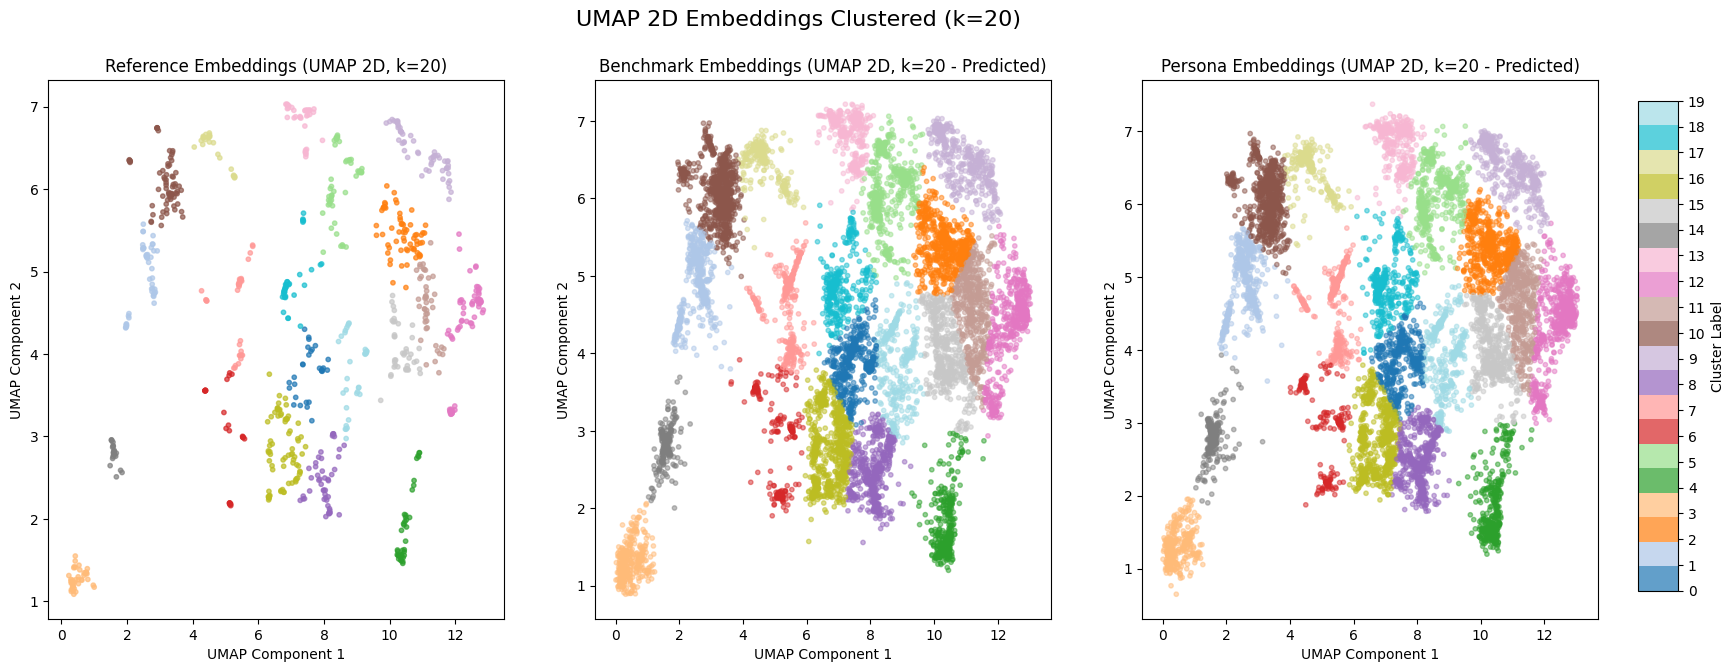


2D UMAP plots generated. Observe how well Benchmark and Persona embeddings align with the Reference clusters.
The tighter and more distinct the groups in the Benchmark/Persona plots, the better the semantic structure is preserved.
------------------------------
ARI (2D UMAP, k=20) - Benchmark: 0.6408
ARI (2D UMAP, k=20) - Persona: 0.6566
Note: These ARIs are based on the 2D reduction for plotting. Your primary ARI results should use the higher-dimensional UMAP reduction if you found that to be better for clustering.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot # For colormaps

# --- 2. Perform Dimension Reduction using UMAP (n_components=2 for plotting) ---
n_components_plot = 2 # Set to 2 for visualization

reducer_plot = umap.UMAP(n_components=n_components_plot,
                         n_neighbors=15, # You can tune this
                         min_dist=0.0,   # You can tune this
                         metric='cosine',
                         random_state=42)
k_clusters = 20 
print(f"Fitting UMAP on Reference embeddings for 2D plot (n_components={n_components_plot})...")
reducer_plot.fit(ref_embs_norm)


ref_embs_reduced_plot = reducer_plot.transform(ref_embs_norm)
all_bench_embs_reduced_plot = reducer_plot.transform(all_bench_embs_norm)
all_pers_embs_reduced_plot = reducer_plot.transform(all_pers_embs_norm)

# Example: Use the k you found to be optimal (e.g., from silhouette score)

# --- 4. Define Reference Clusters (Gold Standard) ---
kmeans_ref_plot = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')
kmeans_ref_plot.fit(ref_embs_reduced_plot)
ref_cluster_labels_plot = kmeans_ref_plot.labels_


# --- 5. Map Job Codes to Reference Clusters (for ground truth labels) ---
code_to_ref_cluster = {}
for i, code in enumerate(ref_embeddings_df.index):
    code_to_ref_cluster[code] = ref_cluster_labels_plot[i]


# --- 6. Create "Ground Truth" Labels for Generated Data (for plotting consistency) ---
true_labels_bench_plot = []
for code in df_clus[df_clus['prompt'] == 'benchmark']['code']:
    true_labels_bench_plot.append(code_to_ref_cluster[code])

true_labels_pers_plot = []
for code in df_clus[df_clus['prompt'] == 'persona']['code']:
    true_labels_pers_plot.append(code_to_ref_cluster[code])

true_labels_bench_plot = np.array(true_labels_bench_plot)
true_labels_pers_plot = np.array(true_labels_pers_plot)


# --- 7. Predict Clusters for Generated Data (using Reference KMeans Model, 2D) ---
predicted_labels_bench_plot = kmeans_ref_plot.predict(all_bench_embs_reduced_plot) 
predicted_labels_pers_plot = kmeans_ref_plot.predict(all_pers_embs_reduced_plot)

print(f"Clustering performed for visualization with k={k_clusters}.")
print("-" * 30)

# --- 6. Create "Ground Truth" Labels for Generated Data (for plotting consistency) ---
# Ensure the codes are extracted directly from the DataFrame slices
# that correspond to the generated embeddings, to guarantee length alignment.

# Get the codes for the exact rows that correspond to all_bench_embs_reduced_plot
job_codes_for_bench_embeddings = df_clus[df_clus['prompt'] == 'benchmark']['code'].values
true_labels_bench_plot = np.array([code_to_ref_cluster[jc] for jc in job_codes_for_bench_embeddings])

# Get the codes for the exact rows that correspond to all_pers_embs_reduced_plot
job_codes_for_pers_embeddings = df_clus[df_clus['prompt'] == 'persona']['code'].values
true_labels_pers_plot = np.array([code_to_ref_cluster[jc] for jc in job_codes_for_pers_embeddings])

print(f"Length of true_labels_bench_plot: {len(true_labels_bench_plot)}")
print(f"Length of predicted_labels_bench_plot: {len(predicted_labels_bench_plot)}")
print(f"Length of true_labels_pers_plot: {len(true_labels_pers_plot)}")
print(f"Length of predicted_labels_pers_plot: {len(predicted_labels_pers_plot)}")
print("-" * 30)

# --- Plotting the 2D UMAP Embeddings and Clusters ---

# Create a color map for consistent coloring across plots
colors = pyplot.get_cmap('tab20', k_clusters) # 'tab20' is good for up to 20 clusters, choose a larger one if k > 20

fig, axes = plt.subplots(1, 3, figsize=(20, 7)) # 1 row, 3 columns for 3 plots

# Plot 1: Reference Embeddings with their assigned clusters
scatter_ref = axes[0].scatter(ref_embs_reduced_plot[:, 0], ref_embs_reduced_plot[:, 1],
                              c=ref_cluster_labels_plot, cmap=colors, s=10, alpha=0.7)
axes[0].set_title(f'Reference Embeddings (UMAP 2D, k={k_clusters})')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
# Add centroids (optional)
# axes[0].scatter(kmeans_ref_plot.cluster_centers_[:, 0], kmeans_ref_plot.cluster_centers_[:, 1],
#                marker='X', s=200, color='black', label='Centroids')
# axes[0].legend()


# Plot 2: Benchmark Embeddings predicted into Reference clusters
scatter_bench = axes[1].scatter(all_bench_embs_reduced_plot[:, 0], all_bench_embs_reduced_plot[:, 1],
                                c=predicted_labels_bench_plot, cmap=colors, s=10, alpha=0.5)
axes[1].set_title(f'Benchmark Embeddings (UMAP 2D, k={k_clusters} - Predicted)')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')


# Plot 3: Persona Embeddings predicted into Reference clusters
scatter_pers = axes[2].scatter(all_pers_embs_reduced_plot[:, 0], all_pers_embs_reduced_plot[:, 1],
                               c=predicted_labels_pers_plot, cmap=colors, s=10, alpha=0.5)
axes[2].set_title(f'Persona Embeddings (UMAP 2D, k={k_clusters} - Predicted)')
axes[2].set_xlabel('UMAP Component 1')
axes[2].set_ylabel('UMAP Component 2')


# Add a single colorbar for all plots (optional, but good for consistent color mapping)
# You might want to adjust its position
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # x, y, width, height
cbar = fig.colorbar(scatter_ref, cax=cbar_ax, ticks=np.linspace(0, k_clusters-1, k_clusters))
cbar.set_label('Cluster Label')

plt.suptitle(f'UMAP 2D Embeddings Clustered (k={k_clusters})', fontsize=16)
plt.show()

print("\n2D UMAP plots generated. Observe how well Benchmark and Persona embeddings align with the Reference clusters.")
print("The tighter and more distinct the groups in the Benchmark/Persona plots, the better the semantic structure is preserved.")
print("-" * 30)

# --- Optional: Recalculate ARI with these 2D clusters for direct comparison to plot ---
# This ARI will likely be lower than if you used higher n_components for clustering,
# but it directly corresponds to what you see in the 2D plot.
ari_bench_plot = adjusted_rand_score(true_labels_bench_plot, predicted_labels_bench_plot)
ari_pers_plot = adjusted_rand_score(true_labels_pers_plot, predicted_labels_pers_plot)

print(f"ARI (2D UMAP, k={k_clusters}) - Benchmark: {ari_bench_plot:.4f}")
print(f"ARI (2D UMAP, k={k_clusters}) - Persona: {ari_pers_plot:.4f}")
print("Note: These ARIs are based on the 2D reduction for plotting. Your primary ARI results should use the higher-dimensional UMAP reduction if you found that to be better for clustering.")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import umap
from scipy import stats # For Wilcoxon test

# --- Configuration ---
# Assuming 'df' is already loaded and contains 'code', 'ref_embeddings', 'gen_embeddings', 'prompt', 'model'
# Filter for the specific model you are analyzing, e.g., "deepseek-r1"
df_clus = df[df["model"] == "deepseek-r1"].copy()

# IMPORTANT: Ensure 'area' and 'zone' columns exist in df_clus
# These columns are crucial for per-group analysis.
# Replace the dummy data creation below with your actual loading/mapping if these columns are not yet in df.
if 'area' not in df_clus.columns:
    print("WARNING: 'area' column not found in df_clus. Creating dummy data for demonstration.")
    # Example dummy area creation: assign randomly to 'IT', 'Healthcare', 'Finance'
    unique_codes = df_clus['code'].unique()
    code_to_area = {code: np.random.choice(['IT', 'Healthcare', 'Finance']) for code in unique_codes}
    df_clus['area'] = df_clus['code'].map(code_to_area)

if 'zone' not in df_clus.columns:
    print("WARNING: 'zone' column not found in df_clus. Creating dummy data for demonstration.")
    # Example dummy zone creation: assign randomly to 'Simple', 'Medium', 'Complex'
    unique_codes = df_clus['code'].unique()
    code_to_zone = {code: np.random.choice(['Simple', 'Medium', 'Complex']) for code in unique_codes}
    df_clus['zone'] = df_clus['code'].map(code_to_zone)

print("Ensured 'area' and 'zone' columns are present in df_clus.")


# --- Global Parameters (from your optimization) ---
num_runs = 20 # Number of times to run the entire process for robustness
n_components = 15 # UMAP target dimensionality
n_neighbors = 15  # UMAP local neighborhood size
min_dist = 0      # UMAP minimum distance between embedded points
k_clusters = 20   # KMeans number of clusters

# --- Data Structures to Store Results Across Runs ---
aris_bench_global_runs = [] # Global ARI for Benchmark
aris_pers_global_runs = []  # Global ARI for Persona

# Get all unique combinations of (area, zone) to prepare storage for per-group ARIs
# This creates keys like "IT - Complex", "Healthcare - Simple"
unique_combined_groups = df_clus[['area', 'zone']].drop_duplicates().apply(lambda x: f"{x['area']} - {x['zone']}", axis=1).tolist()
aris_bench_per_combined_group_runs = {group: [] for group in unique_combined_groups}
aris_pers_per_combined_group_runs = {group: [] for group in unique_combined_groups}


print(f"Starting analysis for {num_runs} iterations with:")
print(f"  UMAP: n_components={n_components}, n_neighbors={n_neighbors}, min_dist={min_dist}")
print(f"  KMeans: k_clusters={k_clusters}")
print(f"  Analyzing {len(unique_combined_groups)} combined groups (area - Zone).")
print("-" * 50)

# --- Main Loop for Robustness Testing ---
for run_idx in range(num_runs):
    # Vary the random state for UMAP and KMeans in each run
    current_random_state = 42 + run_idx 

    print(f"\n--- Run {run_idx + 1}/{num_runs} (Random State: {current_random_state}) ---")

    # --- 1. Prepare All Normalized Embeddings ---
    # Extract unique reference embeddings and normalize them
    ref_embeddings_df = df_clus.drop_duplicates(subset=['code']).set_index('code')
    ref_embs_list = np.stack(ref_embeddings_df['ref_embeddings'].values)
    ref_embs_norm = normalize(ref_embs_list)

    # Extract all generated embeddings for Benchmark and Persona, and normalize them
    bench_data = df_clus[df_clus['prompt'] == 'benchmark'].copy()
    pers_data = df_clus[df_clus['prompt'] == 'persona'].copy()

    all_bench_embs_norm = normalize(np.stack(bench_data['gen_embeddings'].values))
    all_pers_embs_norm = normalize(np.stack(pers_data['gen_embeddings'].values))


    # --- 2. UMAP Dimensionality Reduction (Fit ONLY on Reference, then Transform all) ---
    reducer = umap.UMAP(n_components=n_components,
                         n_neighbors=n_neighbors,
                         min_dist=min_dist,
                         metric='cosine', # Cosine is good for normalized embeddings
                         random_state=current_random_state) # Random state for reproducibility of this run

    # Fit UMAP on the Reference embeddings to define the 'gold standard' projection space
    reducer.fit(ref_embs_norm)

    # Transform all sets of embeddings using the *fitted* UMAP model
    ref_embs_reduced = reducer.transform(ref_embs_norm)
    all_bench_embs_reduced = reducer.transform(all_bench_embs_norm)
    all_pers_embs_reduced = reducer.transform(all_pers_embs_norm)


    # --- 3. Define Reference Clusters (Gold Standard KMeans) ---
    kmeans_ref = KMeans(n_clusters=k_clusters,
                        random_state=current_random_state, # Random state for KMeans init
                        n_init='auto') # 'auto' uses 10 independent runs for initialization, picking the best

    # Fit KMeans on the UMAP-reduced Reference embeddings to define the 'gold standard' clusters
    kmeans_ref.fit(ref_embs_reduced)
    ref_cluster_labels = kmeans_ref.labels_


    # --- 4. Map Job Codes to Reference Clusters, area, and Zone Groups ---
    # This map will link each job code to its reference cluster, area, zone, and combined group
    code_info_map = {}
    for i, row in ref_embeddings_df.reset_index().iterrows():
        code = row['code']
        # Retrieve area and zone from df_clus (assuming consistency)
        info_from_df = df_clus[df_clus['code'] == code].iloc[0]
        area = info_from_df['area']
        zone = info_from_df['zone']

        code_info_map[code] = {
            'ref_cluster': ref_cluster_labels[i],
            'area': area,
            'zone': zone,
            'combined_group': f"{area} - {zone}" # Create the combined group string
        }


    # --- 5. Predict Clusters for Generated Data & Prepare for ARI Calculation ---

    # Lists to store labels for global ARI calculation for this run
    true_labels_bench_global = []
    predicted_labels_bench_global = []
    true_labels_pers_global = []
    predicted_labels_pers_global = []

    # Dictionaries to store true/predicted labels per combined group for this run
    current_run_bench_per_group = {group: {'true': [], 'pred': []} for group in unique_combined_groups}
    current_run_pers_per_group = {group: {'true': [], 'pred': []} for group in unique_combined_groups}

    # Process Benchmark data: predict labels and populate global and per-group lists
    for i, row in bench_data.iterrows():
        code = row['code']
        # Get the corresponding reduced embedding for this row from the `all_bench_embs_reduced` array
        gen_emb_reduced_idx = bench_data.index.get_loc(i)
        gen_emb_reduced = all_bench_embs_reduced[gen_emb_reduced_idx]
        
        # Predict the cluster label using the *fitted Reference KMeans model*
        predicted_label = kmeans_ref.predict(gen_emb_reduced.reshape(1, -1))[0]

        # Get true label and group info from the code_info_map
        ref_info = code_info_map[code]
        true_label = ref_info['ref_cluster']
        combined_group = ref_info['combined_group']

        # Append to global lists
        true_labels_bench_global.append(true_label)
        predicted_labels_bench_global.append(predicted_label)
        
        # Append to per-group lists
        current_run_bench_per_group[combined_group]['true'].append(true_label)
        current_run_bench_per_group[combined_group]['pred'].append(predicted_label)

    # Process Persona data similarly
    for i, row in pers_data.iterrows():
        code = row['code']
        gen_emb_reduced_idx = pers_data.index.get_loc(i)
        gen_emb_reduced = all_pers_embs_reduced[gen_emb_reduced_idx]
        predicted_label = kmeans_ref.predict(gen_emb_reduced.reshape(1, -1))[0]

        ref_info = code_info_map[code]
        true_label = ref_info['ref_cluster']
        combined_group = ref_info['combined_group']

        true_labels_pers_global.append(true_label)
        predicted_labels_pers_global.append(predicted_label)
        current_run_pers_per_group[combined_group]['true'].append(true_label)
        current_run_pers_per_group[combined_group]['pred'].append(predicted_label)


    # --- 6. Calculate ARI for this run (Global & Per-Combined-Group) ---

    # Calculate Global ARIs for the current run
    ari_bench_global = adjusted_rand_score(true_labels_bench_global, predicted_labels_bench_global)
    ari_pers_global = adjusted_rand_score(true_labels_pers_global, predicted_labels_pers_global)
    aris_bench_global_runs.append(ari_bench_global)
    aris_pers_global_runs.append(ari_pers_global)
    print(f"  Global ARI Benchmark: {ari_bench_global:.4f}")
    print(f"  Global ARI Persona:   {ari_pers_global:.4f}")

    # Calculate Per-Combined-Group ARIs for the current run
    # These are stored in the aris_bench/pers_per_combined_group_runs dictionaries
    # NaN is used if a group has insufficient data for a valid ARI calculation
    for group_name in unique_combined_groups:
        true_g_bench = np.array(current_run_bench_per_group[group_name]['true'])
        pred_g_bench = np.array(current_run_bench_per_group[group_name]['pred'])
        true_g_pers = np.array(current_run_pers_per_group[group_name]['true'])
        pred_g_pers = np.array(current_run_pers_per_group[group_name]['pred'])

        ari_g_bench = np.nan # Default to NaN if not enough data
        if len(true_g_bench) > 1 and len(np.unique(true_g_bench)) > 1:
            ari_g_bench = adjusted_rand_score(true_g_bench, pred_g_bench)
        aris_bench_per_combined_group_runs[group_name].append(ari_g_bench)

        ari_g_pers = np.nan # Default to NaN if not enough data
        if len(true_g_pers) > 1 and len(np.unique(true_g_pers)) > 1:
            ari_g_pers = adjusted_rand_score(true_g_pers, pred_g_pers)
        aris_pers_per_combined_group_runs[group_name].append(ari_g_pers)


# --- Final Results Summary Across All Runs ---
print("\n" + "=" * 50)
print("--- Overall Results Across All Runs ---")
print("=" * 50)

# Convert lists of ARIs to numpy arrays for easier statistics, handling NaNs
aris_bench_global_runs_np = np.array(aris_bench_global_runs)
aris_pers_global_runs_np = np.array(aris_pers_global_runs)

print(f"Mean Global ARI (Benchmark vs Reference): {np.nanmean(aris_bench_global_runs_np):.4f} "
      f"(Std Dev: {np.nanstd(aris_bench_global_runs_np):.4f})")
print(f"Mean Global ARI (Persona vs Reference):   {np.nanmean(aris_pers_global_runs_np):.4f} "
      f"(Std Dev: {np.nanstd(aris_pers_global_runs_np):.4f})")

# --- Global Statistical Comparison (Wilcoxon Signed-Rank Test) ---
# Tests if Persona's median ARI is significantly greater than Benchmark's
if len(aris_bench_global_runs_np) > 1 and len(aris_pers_global_runs_np) > 1:
    stat, p_value = stats.wilcoxon(aris_pers_global_runs_np, aris_bench_global_runs_np, alternative='greater', nan_policy='omit')
    print(f"\nWilcoxon signed-rank test (Global ARI, Persona > Benchmark):")
    print(f"  Statistic = {stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  Persona's global alignment is statistically SIGNIFICANTLY HIGHER than Benchmark's (p < 0.05).")
    else:
        print("  No statistically significant global difference (or Persona is not higher) between Persona and Benchmark's alignment.")
else:
    print("Not enough runs for global statistical comparison.")


print("\n" + "=" * 50)
print("--- Per-Combined-Group ARI Summary ---")
print("=" * 50)

# Sort groups alphabetically for consistent output
sorted_combined_groups = sorted(unique_combined_groups)

for group_name in sorted_combined_groups:
    bench_group_aris = np.array(aris_bench_per_combined_group_runs[group_name])
    pers_group_aris = np.array(aris_pers_per_combined_group_runs[group_name])

    # Filter out NaNs if a group had too few samples in some runs for ARI calculation
    bench_group_aris_filtered = bench_group_aris[~np.isnan(bench_group_aris)]
    pers_group_aris_filtered = pers_group_aris[~np.isnan(pers_group_aris)]

    # Only print and perform stats if there's valid data for both models in this group
    if len(bench_group_aris_filtered) > 0 and len(pers_group_aris_filtered) > 0:
        mean_bench = np.nanmean(bench_group_aris_filtered)
        std_bench = np.nanstd(bench_group_aris_filtered)
        mean_pers = np.nanmean(pers_group_aris_filtered)
        std_pers = np.nanstd(pers_group_aris_filtered)

        print(f"\nGroup: {group_name}")
        print(f"  Mean ARI (Benchmark): {mean_bench:.4f} (Std Dev: {std_bench:.4f})")
        print(f"  Mean ARI (Persona):   {mean_pers:.4f} (Std Dev: {std_pers:.4f})")

        # Per-group statistical comparison
        # Need at least 2 valid (non-NaN) values per model for a statistical test
        if len(bench_group_aris_filtered) > 1 and len(pers_group_aris_filtered) > 1:
            stat_g, p_value_g = stats.wilcoxon(pers_group_aris_filtered, bench_group_aris_filtered, alternative='greater', nan_policy='omit')
            print(f"  Wilcoxon (Persona > Bench): p-value = {p_value_g:.4f}")
            if p_value_g < 0.05:
                print(f"    Persona is statistically SIGNIFICANTLY HIGHER in '{group_name}'.")
            elif p_value_g > 0.05 and p_value_g < 0.1: # Consider a weaker significance level
                print(f"    Persona is potentially higher in '{group_name}' (p < 0.10).")
            else:
                print(f"    No statistically significant difference in '{group_name}' (or Persona not higher).")
        else:
            print("  Not enough valid runs for per-group statistical comparison (need >1 non-NaN ARI).")
    else:
        print(f"\nGroup: {group_name} - Not enough valid data points across runs for ARI calculation for both models.")

Ensured 'area' and 'zone' columns are present in df_clus.
Starting analysis for 20 iterations with:
  UMAP: n_components=15, n_neighbors=15, min_dist=0
  KMeans: k_clusters=20
  Analyzing 70 combined groups (area - Zone).
--------------------------------------------------

--- Run 1/20 (Random State: 42) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6707
  Global ARI Persona:   0.6819

--- Run 2/20 (Random State: 43) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6742
  Global ARI Persona:   0.6872

--- Run 3/20 (Random State: 44) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6921
  Global ARI Persona:   0.7059

--- Run 4/20 (Random State: 45) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.7249
  Global ARI Persona:   0.7349

--- Run 5/20 (Random State: 46) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6513
  Global ARI Persona:   0.6644

--- Run 6/20 (Random State: 47) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6956
  Global ARI Persona:   0.6925

--- Run 7/20 (Random State: 48) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.7008
  Global ARI Persona:   0.7052

--- Run 8/20 (Random State: 49) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6757
  Global ARI Persona:   0.6835

--- Run 9/20 (Random State: 50) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6991
  Global ARI Persona:   0.7000

--- Run 10/20 (Random State: 51) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6991
  Global ARI Persona:   0.7089

--- Run 11/20 (Random State: 52) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.7083
  Global ARI Persona:   0.7208

--- Run 12/20 (Random State: 53) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6723
  Global ARI Persona:   0.6869

--- Run 13/20 (Random State: 54) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.7025
  Global ARI Persona:   0.7132

--- Run 14/20 (Random State: 55) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6811
  Global ARI Persona:   0.6884

--- Run 15/20 (Random State: 56) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6950
  Global ARI Persona:   0.7070

--- Run 16/20 (Random State: 57) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6732
  Global ARI Persona:   0.6711

--- Run 17/20 (Random State: 58) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6722
  Global ARI Persona:   0.6899

--- Run 18/20 (Random State: 59) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6703
  Global ARI Persona:   0.6800

--- Run 19/20 (Random State: 60) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6727
  Global ARI Persona:   0.6889

--- Run 20/20 (Random State: 61) ---


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Global ARI Benchmark: 0.6892
  Global ARI Persona:   0.6968

--- Overall Results Across All Runs ---
Mean Global ARI (Benchmark vs Reference): 0.6860 (Std Dev: 0.0169)
Mean Global ARI (Persona vs Reference):   0.6954 (Std Dev: 0.0165)

Wilcoxon signed-rank test (Global ARI, Persona > Benchmark):
  Statistic = 205.0000, p-value = 0.0000
  Persona's global alignment is statistically SIGNIFICANTLY HIGHER than Benchmark's (p < 0.05).

--- Per-Combined-Group ARI Summary ---

Group: 11 - 2
  Mean ARI (Benchmark): 0.8680 (Std Dev: 0.0548)
  Mean ARI (Persona):   0.9607 (Std Dev: 0.0286)
  Wilcoxon (Persona > Bench): p-value = 0.0000
    Persona is statistically SIGNIFICANTLY HIGHER in '11 - 2'.

Group: 11 - 3
  Mean ARI (Benchmark): 0.6302 (Std Dev: 0.0913)
  Mean ARI (Persona):   0.6967 (Std Dev: 0.0990)
  Wilcoxon (Persona > Bench): p-value = 0.0001
    Persona is statistically SIGNIFICANTLY HIGHER in '11 - 3'.

Group: 11 - 4
  Mean ARI (Benchmark): 0.6480 (Std Dev: 0.0515)
  Mean ARI (Pe

In [ ]:
# --- Final Results Summary: Output to DataFrames ---
print("\n" + "=" * 50)
print("--- Generating Final Result DataFrames ---")
print("=" * 50)

# Convert lists of ARIs to numpy arrays for easier statistics, handling NaNs
aris_bench_global_runs_np = np.array(aris_bench_global_runs)
aris_pers_global_runs_np = np.array(aris_pers_global_runs)

# --- Global ARI Summary DataFrame ---
global_results_data = []

# Calculate global means and std devs
mean_bench_global = np.nanmean(aris_bench_global_runs_np)
std_bench_global = np.nanstd(aris_bench_global_runs_np)
mean_pers_global = np.nanmean(aris_pers_global_runs_np)
std_pers_global = np.nanstd(aris_pers_global_runs_np)

global_results_data.append({
    'Model': 'Benchmark',
    'Mean ARI': mean_bench_global,
    'Std Dev ARI': std_bench_global
})
global_results_data.append({
    'Model': 'Persona',
    'Mean ARI': mean_pers_global,
    'Std Dev ARI': std_pers_global
})

global_results_df = pd.DataFrame(global_results_data)
print("\n--- Global ARI Results ---")
print(global_results_df.round(4).to_string()) # Use to_string() to display all rows/columns

# --- Global Statistical Comparison ---
global_stat_data = []
if len(aris_bench_global_runs_np) > 1 and len(aris_pers_global_runs_np) > 1:
    # Two-sided Wilcoxon test
    stat, p_value = stats.wilcoxon(aris_pers_global_runs_np, aris_bench_global_runs_np, alternative='two-sided', nan_policy='omit')
    
    significance_global = "Not Significant"
    if p_value < 0.001:
        significance_global = "Highly Significant (p < 0.001)"
    elif p_value < 0.01:
        significance_global = "Very Significant (p < 0.01)"
    elif p_value < 0.05:
        significance_global = "Significant (p < 0.05)"
    elif p_value < 0.1:
        significance_global = "Marginally Significant (p < 0.1)"

    # Determine which model is better based on means if significant
    better_model_global = "No significant difference"
    if p_value < 0.1: # Only determine direction if there's at least marginal significance
        if mean_pers_global > mean_bench_global:
            better_model_global = "Persona"
        elif mean_bench_global > mean_pers_global:
            better_model_global = "Benchmark"

    global_stat_data.append({
        'Test': 'Wilcoxon',
        'p-value': p_value,
        'Significance': significance_global,
        'Better Model': better_model_global
    })
else:
    global_stat_data.append({
        'Test': 'Wilcoxon',
        'p-value': np.nan,
        'Significance': 'Not enough runs',
        'Better Model': 'N/A'
    })

global_stat_df = pd.DataFrame(global_stat_data)
print("\n--- Global Statistical Comparison ---")
print(global_stat_df.round(4).to_string())


# --- Per-Combined-Group ARI Summary DataFrame ---
per_group_results_data = []

# Sort groups alphabetically for consistent output
sorted_combined_groups = sorted(unique_combined_groups)

for group_name in sorted_combined_groups:
    bench_group_aris = np.array(aris_bench_per_combined_group_runs[group_name])
    pers_group_aris = np.array(aris_pers_per_combined_group_runs[group_name])

    # Filter out NaNs (from groups with too few samples in some runs)
    bench_group_aris_filtered = bench_group_aris[~np.isnan(bench_group_aris)]
    pers_group_aris_filtered = pers_group_aris[~np.isnan(pers_group_aris)]

    row_data = {
        'Combined Group': group_name,
        'Mean ARI (Benchmark)': np.nan,
        'Std Dev (Benchmark)': np.nan,
        'Mean ARI (Persona)': np.nan,
        'Std Dev (Persona)': np.nan,
        'Wilcoxon p-value': np.nan,
        'Significance': 'N/A',
        'Better Model': 'N/A'
    }

    if len(bench_group_aris_filtered) > 0 and len(pers_group_aris_filtered) > 0:
        mean_bench = np.nanmean(bench_group_aris_filtered)
        std_bench = np.nanstd(bench_group_aris_filtered)
        mean_pers = np.nanmean(pers_group_aris_filtered)
        std_pers = np.nanstd(pers_group_aris_filtered)

        row_data['Mean ARI (Benchmark)'] = mean_bench
        row_data['Std Dev (Benchmark)'] = std_bench
        row_data['Mean ARI (Persona)'] = mean_pers
        row_data['Std Dev (Persona)'] = std_pers

        # Per-group statistical comparison
        # Need at least 2 non-NaN values per model for a statistical test
        if len(bench_group_aris_filtered) > 1 and len(pers_group_aris_filtered) > 1:
            # Two-sided Wilcoxon test
            stat_g, p_value_g = stats.wilcoxon(pers_group_aris_filtered, bench_group_aris_filtered, alternative='two-sided', nan_policy='omit')
            row_data['Wilcoxon p-value'] = p_value_g

            significance_g = "Not Significant"
            if p_value_g < 0.001:
                significance_g = "Highly Significant (p < 0.001)"
            elif p_value_g < 0.01:
                significance_g = "Very Significant (p < 0.01)"
            elif p_value_g < 0.05:
                significance_g = "Significant (p < 0.05)"
            elif p_value_g < 0.1:
                significance_g = "Marginally Significant (p < 0.1)"
            row_data['Significance'] = significance_g

            # Determine which model is better based on means if significant
            if p_value_g < 0.1: # Only determine direction if there's at least marginal significance
                if mean_pers > mean_bench:
                    row_data['Better Model'] = "Persona"
                elif mean_bench > mean_pers:
                    row_data['Better Model'] = "Benchmark"
            else:
                row_data['Better Model'] = "No significant difference"
        else:
            row_data['Significance'] = 'Not enough runs for stats'
            row_data['Better Model'] = 'N/A'
    else:
        row_data['Significance'] = 'Not enough data for ARI'
        row_data['Better Model'] = 'N/A'
    
    per_group_results_data.append(row_data)

per_group_results_df = pd.DataFrame(per_group_results_data)
print("\n--- Per-Combined-Group ARI Results ---")
print(per_group_results_df.round(4).to_string()) # Use to_string() to display all rows/columns


--- Generating Final Result DataFrames ---

--- Global ARI Results ---
       Model  Mean ARI  Std Dev ARI
0  Benchmark    0.6860       0.0169
1    Persona    0.6954       0.0165

--- Global Statistical Comparison ---
       Test  p-value                    Significance Better Model
0  Wilcoxon      0.0  Highly Significant (p < 0.001)      Persona

--- Per-Combined-Group ARI Results ---
   Combined Group  Mean ARI (Benchmark)  Std Dev (Benchmark)  Mean ARI (Persona)  Std Dev (Persona)  Wilcoxon p-value                      Significance               Better Model
0          11 - 2                0.8680               0.0548              0.9607             0.0286            0.0001    Highly Significant (p < 0.001)                    Persona
1          11 - 3                0.6302               0.0913              0.6967             0.0990            0.0003    Highly Significant (p < 0.001)                    Persona
2          11 - 4                0.6480               0.0515            